In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
from os import walk, listdir
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

import random
random.seed(10)

def get_data_per_condition(address, condition):
    subjects = listdir(''.join([address, condition, '/']))
    data = [loadmat(''.join([address, condition, '/', subject]))[subject.split('.')[0]] for subject in subjects]
    data = np.asarray(data)
    print('Shape: ', data.shape)
    return data

def get_x_y(slc, selected_regions, all_regions):
    reg_indx = [i for i, e in enumerate(all_regions) if e in selected_regions]
    x = np.concatenate([b_data[:,slc,reg_indx], u_data[:,slc,reg_indx]])
    y = np.concatenate([-np.ones((num_subj)), np.ones((num_subj))])
    
    names = selected_regions
    
    df = pd.DataFrame(x, columns=names)
    df['class'] = y
    return x, y, df


In [2]:
# Read data
# folder = 'conclusion_event_two_conditions_wtmean'
# folder = 'conclusion_event_two_conditions_median'

# folder = 'premise_event_threeconditions' # This is weighted mean
# folder = 'premise_event_threeconditions_median'
folder = 'premise_event_threeconditions_mean'
address = ''.join(['../analyses/out/', folder,'/young/'])

b_data = get_data_per_condition(address, 'Beleivable')
# n_data = get_data_per_condition(address, 'Neutral')
u_data = get_data_per_condition(address, 'Unbeleivable')

reg_cords = np.asarray([line.rstrip('\n').split('\t') for line in open('rois.txt')])
region_names = reg_cords[:,0]
num_subj = b_data.shape[0]
max_slc = b_data.shape[1]
num_regions = b_data.shape[2]

Shape:  (28, 18, 70)
Shape:  (28, 18, 70)


In [3]:
# Selected based on relelvance and reports from previous articles in logical reasoning.

selected_regions = ['ACG.L', 'ACG.R', 'AMYG.L', 'AMYG.R', 'ANG.L', 'ANG.R', 'CAU.L', 'CAU.R', 'CUN.L', 'CUN.R', 
                    'FFG.L', 'FFG.R', 'HIP.L', 'HIP.R', 'IFGoperc.L', 'IFGoperc.R', 'IFGtriang.L', 'IFGtriang.R', 
                    'INS.L', 'INS.R', 'IPL.L', 'IPL.R', 'MTG.L', 'MTG.R', 'ORBinf.L', 'ORBinf.R', 'ORBmid.L', 'ORBmid.R', 
                    'ORBsup.L', 'ORBsup.R', 'ORBsupmed.L', 'ORBsupmed.R', 'PCUN.L', 'PCUN.R', 'PUT.L', 'PUT.R', 
                    'ROL.L', 'ROL.R', 'SFGdor.L', 'SFGdor.R', 'SFGmed.L', 'SFGmed.R', 'SPG.L', 'SPG.R', 
                    'STG.L', 'STG.R', 'THA.L', 'THA.R',  'PCG.L', 'PCG.R']
st = set(selected_regions)
reg_indx = [i for i, e in enumerate(region_names) if e in st]
reg_cords = reg_cords[reg_indx, :]
b_data = b_data[:, :, reg_indx]
u_data = u_data[:,:, reg_indx]
region_names = region_names[reg_indx]
num_regions = b_data.shape[2]

In [4]:
num_regions

50

In [5]:
_,_,df = get_x_y(3, region_names, region_names)
df.to_csv('tr3.csv', index = False, header=True)

In [86]:
# Compare models per slice
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import ElasticNetCV, SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Basic methods used for modeling
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer
from sklearn.feature_selection import RFE
import warnings

available_models={'LDA': LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
            ,'SVM_l1': LinearSVC(penalty='l1', dual=False, max_iter=40000, C=1.0)
            ,'LR': LogisticRegression(solver='lbfgs')
            ,'SVM': LinearSVC(max_iter=4000)
            ,'GPC': GaussianProcessClassifier(kernel=1.0 * DotProduct(sigma_0=1.0)**2)
            ,'ENET': SGDClassifier(penalty='elasticNet')
            ,'DTR': DecisionTreeClassifier()
            ,'RNF': RandomForestClassifier(n_estimators=100)
            ,'GBT': GradientBoostingClassifier(n_estimators=100)
            ,'EXT': ExtraTreesClassifier()
            ,'QDA': QuadraticDiscriminantAnalysis()
#             ,'OEC': LinearOEC(x.shape[1], optimizer='cmaes',regularization=0.2, iterations=2000)
           }

# Compare against random shuffle

In [49]:
from scipy.stats import ttest_ind

def cohensd(d1: np.array, d2: np.array):
    # see paper: Using Effect Size—or Why the P Value Is Not Enough
    d1 = d1.copy()
    d2 = d2.copy()

    d1 /= np.std(d2)
    d2 /= np.std(d2)
    # calculate the size of samples
    n1, n2 = d1.shape[0], d2.shape[0]
    # calculate the variance of the samples
    s1, s2 = d1.var(ddof=1), d2.var(ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = d1.mean(), d2.mean()
    # calculate the effect size
    return (u1 - u2) / s

# Random selection method for permutation tests
def random_selection(y, perc):
    first_one = np.argmax(y==1)
    s = np.int32(np.floor(first_one*perc))
    perm = np.random.permutation(first_one)
    indices = perm[0:s]
    selected_indices = np.concatenate([indices, indices+first_one])
    indices = perm[s:]
    rest_indices = np.concatenate([indices, indices+first_one])
    return selected_indices, rest_indices

def single_model_run(model, x, y, selected, rest, num_f=0, standard=None):
            
    if model_name == 'Rand':
        y_hat = np.random.randint(2, size=rest.shape[0])
    else:

        if num_f > 0:
            sk = SelectKBest(f_classif, k=num_f)
            x_train = sk.fit_transform(abs(x[selected, :]), y[selected])                
            x_test = sk.transform(abs(x[rest, :]))
        else:                
            x_train = x[selected,:]
            x_test = x[rest, :]

        if standard is not None:
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model.fit(x_train, y[selected])  

        y_hat = model.predict(x_test)
        y_hat_train = model.predict(x_train)
        

    return metrics.accuracy_score(y[rest], y_hat), metrics.accuracy_score(y[selected], y_hat_train), model


def model_runner(models, x, y, perc=0.7, runs=100, num_f=0, shuffle=False, standard=None):
    # Runs multiple models (models) on x and y, with 'perc' for training, over 'runs' number of runs. 
    # Reduces the number of dimensions to num_f if it is larger than zero. Shuffles the x if shuffle is true, useful for 
    # testing how reliable the results are.
    res= {}
    for model_name in models.keys():
        res[model_name] = []
    
    res_train= {}
    for model_name in models.keys():
        res_train[model_name] = []
    
    for i in range(runs):
        acc = []
        if shuffle: # Test against shuffle
            np.random.shuffle(x)
        
        for model_name in models.keys():  
            selected, rest = random_selection(y, perc)
            m, m_train, _ = single_model_run(model, x, y, selected, rest, num_f=num_f, standard=standard)
            res[model_name].append(m)
            res_train[model_name].append(m_train)
            
    return res, res_train

def get_model_accuracy_against_shuffle(model, model_name, slc, dimensionality_reduction=0, perc=0.7, runs=100, standard=None):
    test_res = []
    means = []
    x, y, df = get_x_y(slc, region_names, region_names)
    models = {'Other': model}
    
    res, res_train = model_runner(models, x, y, perc, runs, num_f=dimensionality_reduction, shuffle=False, standard=standard)
    all_acc_dt = res['Other']
    all_acc_dtrain = res_train['Other']
    
    res, res_train = model_runner(models, x, y, perc, runs, num_f=dimensionality_reduction, shuffle=True, standard=standard)
    all_acc_sf = res['Other']
    all_acc_srain = res_train['Other']

    test_res = ttest_ind(all_acc_sf, all_acc_dt)
    cohensd_val = cohensd(all_acc_sf, all_acc_dt)
    
    means = np.mean(all_acc_dt)

    return all_acc_dt, test_res, means, cohensd_val

In [50]:
models_to_test = {'SVM_l1'}
# models_to_test = {'SVM'}
# models_to_test = {'GBT'}


models={key:value for key,value in available_models.items() if key in models_to_test}

all_methods_comparison = pd.DataFrame()
all_comps = []
model_shuffle_t_test = []
significant_trs = []
model_stats = []
train_perc = 0.9
runs = 2000

# scaler = None
# scaler = StandardScaler()
# scaler = MinMaxScaler((-1, 1))
scaler = RobustScaler()
# scaler = MaxAbsScaler()
# scaler = Normalizer()

for slc in range(max_slc):
    temp_df = pd.DataFrame()
    for model_name in models_to_test:
        model = available_models[model_name]
        all_acc_dt, test_res, means, cohensd_val = get_model_accuracy_against_shuffle(model, model_name, slc, 
                                                                         dimensionality_reduction=0, 
                                                                         perc=train_perc, runs=runs, 
                                                                         standard=scaler)
        if (test_res[1]<0.05) and (test_res[0]<0): # Better than shuffle
            temp_df[model_name] = all_acc_dt
        model_shuffle_t_test.append(test_res)
        
        if test_res[0] < 0 and test_res[1]<0.05:
            significant_trs.append(slc)
            
            
        d = np.asarray(all_acc_dt)
        print('TR: {0}, t_stat: {1:3.2f}, p: {2:3.4f}, mean: {3:3.3f}, std: {4:3.3f}, cohensd: {5:1.3f}'.format(
            slc, test_res[0], test_res[1], means, d.std(), cohensd_val))
        
        model_stats.append([slc, test_res[0], test_res[1], d.mean(), d.std(), cohensd_val])

TR: 0, t_stat: 14.80, p: 0.0000, mean: 0.419, std: 0.175, cohensd: 0.468
TR: 1, t_stat: -19.78, p: 0.0000, mean: 0.616, std: 0.179, cohensd: -0.625
TR: 2, t_stat: -6.85, p: 0.0000, mean: 0.531, std: 0.162, cohensd: -0.217
TR: 3, t_stat: -31.04, p: 0.0000, mean: 0.682, std: 0.176, cohensd: -0.981
TR: 4, t_stat: -7.11, p: 0.0000, mean: 0.537, std: 0.167, cohensd: -0.225
TR: 5, t_stat: -10.70, p: 0.0000, mean: 0.560, std: 0.172, cohensd: -0.338
TR: 6, t_stat: -17.17, p: 0.0000, mean: 0.611, std: 0.187, cohensd: -0.543
TR: 7, t_stat: 4.57, p: 0.0000, mean: 0.477, std: 0.157, cohensd: 0.144
TR: 8, t_stat: 2.46, p: 0.0141, mean: 0.482, std: 0.154, cohensd: 0.078
TR: 9, t_stat: -6.95, p: 0.0000, mean: 0.534, std: 0.152, cohensd: -0.220
TR: 10, t_stat: -8.79, p: 0.0000, mean: 0.556, std: 0.160, cohensd: -0.278
TR: 11, t_stat: -8.81, p: 0.0000, mean: 0.552, std: 0.153, cohensd: -0.279
TR: 12, t_stat: 18.90, p: 0.0000, mean: 0.395, std: 0.167, cohensd: 0.598
TR: 13, t_stat: 14.48, p: 0.0000, mea

In [51]:
# Significance of separation accross different TR
df = pd.DataFrame(np.asarray(model_stats), columns=['TR', 't_stat', 'p_val', 'mean', 'std', 'cohensd_val'])
df.to_clipboard()
df

TR     t_stat          p_val      mean       std  cohensd_val
0    0.0  14.795827   2.884829e-48  0.419417  0.175018     0.467885
1    1.0 -19.778954   3.792054e-83  0.615583  0.179006    -0.625465
2    2.0  -6.847559   8.659919e-12  0.531500  0.161871    -0.216539
3    3.0 -31.036915  1.113150e-189  0.682333  0.175765    -0.981473
4    4.0  -7.105886   1.409041e-12  0.537333  0.167234    -0.224708
5    5.0 -10.695793   2.411264e-26  0.559667  0.171823    -0.338231
6    6.0 -17.166448   8.694579e-64  0.610833  0.186695    -0.542851
7    7.0   4.568682   5.056007e-06  0.476917  0.157261     0.144474
8    8.0   2.456538   1.407051e-02  0.481583  0.154317     0.077683
9    9.0  -6.948696   4.285855e-12  0.534417  0.152102    -0.219737
10  10.0  -8.789644   2.189562e-18  0.555583  0.160232    -0.277953
11  11.0  -8.813938   1.770563e-18  0.552500  0.153005    -0.278721
12  12.0  18.903753   2.084546e-76  0.395167  0.166613     0.597789
13  13.0  14.476471   2.487350e-46  0.426750  0.127076     0.457786
14  14.0  18.536128   1.187688e-73  0.392583  0.163988     0.586164
15  15.0  10.583755   7.763630e-26  0.433083  0.161443     0.334688
16  16.0   2.560508   1.048835e-02  0.487667  0.171960     0.080970
17  17.0  -7.622160   3.096746e-14  0.541583  0.177032    -0.241034

In [52]:
significant_trs=np.asarray(significant_trs)
significant_trs

array([ 1,  2,  3,  4,  5,  6,  9, 10, 11, 17])

# Regions Importances

In [87]:
# Generate variables importance for each time slice
def get_importance_measures(model, x, y, var_names, perc=0.7, runs=100, standard=None):
    scales = np.zeros((runs, var_names.shape[0]))
    count = np.zeros((runs, var_names.shape[0]))
    rank = np.zeros((runs, var_names.shape[0]))
    val = np.zeros((runs, var_names.shape[0]))
    
    for i in range(runs):
        s, r = random_selection(y,perc)
        x_train = x[s,:]
        x_test = x[r,:]
        if standard is not None:
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
                
        model.fit(x_train, y[s])
        if hasattr(model, 'feature_importances_'):
            imp = abs(model.feature_importances_)
        else:
            imp = abs(model.coef_[0])
        val[i,:] = model.coef_[0]
        imp /= sum(imp) # Normalize to sum=1, so that the most important one has a "1" coefficient
        scales[i,:] = imp
        count[i,imp>0] += 1
        rank[i,:] = imp.argsort().argsort()        
        
    return scales, count, rank, val

def get_importance_measures1(model, x, y, var_names, perc=0.7, runs=100, standard=None):
    scales = np.zeros((runs, var_names.shape[0]))
    count = np.zeros((runs, var_names.shape[0]))
    rank = np.zeros((runs, var_names.shape[0]))
    val = np.zeros((runs, var_names.shape[0]))
    selected = np.zeros((runs, var_names.shape[0]))
    
    for i in range(runs):
        f_perc = int(np.floor(.5*var_names.shape[0]))
        all_f = np.arange(var_names.shape[0])
        fs = np.random.choice(all_f, f_perc, replace=False)
        fs.sort()
#         print(fs.shape)
        
        s, r = random_selection(y,perc)  
        xx = x[:,fs]
        x_train = xx[s,:]
        x_test = xx[r,:]
        
        if standard is not None:
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
                
        model.fit(x_train, y[s])
        if hasattr(model, 'feature_importances_'):
            imp = abs(model.feature_importances_)
        else:
            imp = abs(model.coef_[0])
        val[i,fs] = model.coef_[0]
        imp /= sum(imp) # Normalize to sum=1, so that the most important one has a "1" coefficient
        scales[i,fs] = imp
        count[i,fs[imp>0]] += 1
        rank[i,fs] = imp.argsort().argsort()
        selected[i,fs] += 1
        
    return scales, count, rank, val, selected

def get_importance_all_slices(model, max_slc, region_names, perc=0.7, runs=1000, show=False, thr=0.1, get_abs=False):
    regions_importance_scale = np.zeros((max_slc, len(region_names)))
    regions_importance_count = np.zeros((max_slc, len(region_names)))
    regions_importance_rank = np.zeros((max_slc, len(region_names)))
    regions_importance_val = np.zeros((max_slc, len(region_names)))
    
    for slc in range(0, max_slc):
        print('Slice number: ', slc)
        x, y, df = get_x_y(slc, region_names, region_names)
        
        if get_abs:
            x = abs(x)
#         x=abs(x)
        ss, cc, rr, vv = get_importance_measures(model,x,y, region_names, perc=perc, runs=runs)
        
        regions_importance_scale[slc,:] = ss.mean(axis=0)
        regions_importance_count[slc,:] = cc.mean(axis=0)
        regions_importance_rank[slc,:] = rr.mean(axis=0)
        regions_importance_val[slc,:] = vv.mean(axis=0)
        
        if show==True:
            which_sol = cc
            indx = np.where(which_sol.mean(axis=0)>thr)
            
            temp_df = pd.DataFrame(np.squeeze(which_sol[:,indx]), columns=[region_names[indx]])
            temp_df = temp_df.melt(var_name='Region', value_name='Importance')
            sns.set(font_scale=3)  # crazy big
            sns.set(rc={'figure.figsize':(11,8)})
            sns.barplot(x='Region', y='Importance', data=temp_df)

            plt.show()
    return regions_importance_scale, regions_importance_count, regions_importance_rank, regions_importance_val

# Visualize importance of each region in time
def show_importance_by_region(x, importance_measure, selected_regions, all_regions, x_label, y_label):
    st = set(selected_regions)

    reg_indx = [i for i, e in enumerate(all_regions) if e in st]

    y = importance_measure[:, reg_indx]
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 22})

    plt.plot(x, y, linewidth=3.0)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(selected_regions)
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.show()
    
def bootstrap(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

def get_region_coef_distr(reg_name, bootstrap_ci, d, v, show=False):
    b = bootstrap(v)(bootstrap_ci)
    
    """
    Generate a histogram of the distribution of sample means for 
    5000 bootstrap resamplings.
    """

    sns.set(style="darkgrid")

    xbar_init = np.round(np.mean(v), 2)

    # generate 5000 resampled sample means  =>
    means = [np.mean(np.random.choice(v, size=len(v),replace=True)) for i in range(5000)]
    print('Region: {0}, ci: ({1:3.4f}, ci: {2:3.4f}), bagged importance level: {3:3.4f} , importance stability factor: {4:3.4f}'.format(
        reg_name, b[0], b[1], np.median(means), d))
    
    if show:
        sns.distplot(means, color='r', kde=True, hist_kws=dict(edgecolor="b", linewidth=.675))
        plt.xlabel("Initial Sample Mean: {}".format(xbar_init))
        plt.title(''.join(["Distribution of Coefficient Mean for ", reg_name]))
        plt.axvline(x=xbar_init) # vertical line at xbar_init
        plt.show()
    
    return np.asarray(means)

In [88]:
# Per time slice, use the model, perform bootstrap aggregation (subject and region), 
# and report if a region was important in more than 95% 0f runs

model =available_models['SVM_l1']
regions_importance_portion = np.zeros((region_names.shape[0], max_slc))
regions_importance_values = []
regions_importance_ranks = []
regions_importance_selected = []
runs = 2000

importance_threshold=0.95

for slc in range(max_slc):
    x, y, df = get_x_y(slc, region_names, region_names)

    s,c,r,v,sel = get_importance_measures1(model,x,y, region_names, perc=train_perc, runs=runs, standard=scaler)
    c_sum = c.sum(axis=0)    
    c_sum /= sel.sum(axis=0)
    regions_importance_portion[:,slc] = c_sum
    
#     # Get number of times the coefficient was non-zero  
    regions_importance_values.append(v)
    regions_importance_ranks.append(r)
    regions_importance_selected.append(sel)
    
    d = regions_importance_portion[:,slc]
    print('TR: {0}, t_stat: {1:3.2f}, p: {2:3.4f}'.format(slc, model_shuffle_t_test[slc][0], model_shuffle_t_test[slc][1]), 
          ', Regions: ', region_names[d>importance_threshold])
    
    
regions_importance_ranks = np.asarray(regions_importance_ranks)

TR: 0, t_stat: 14.80, p: 0.0000 , Regions:  ['AMYG.R' 'FFG.R' 'IPL.L' 'MTG.R' 'PUT.L' 'SFGdor.L']
TR: 1, t_stat: -19.78, p: 0.0000 , Regions:  ['AMYG.R' 'FFG.R' 'IFGtriang.L' 'MTG.L' 'ORBinf.L' 'PUT.L' 'STG.L' 'THA.L']
TR: 2, t_stat: -6.85, p: 0.0000 , Regions:  ['FFG.R' 'IFGtriang.L' 'INS.R' 'PCG.R' 'PUT.L' 'STG.L']
TR: 3, t_stat: -31.04, p: 0.0000 , Regions:  ['AMYG.L' 'FFG.R' 'HIP.R' 'INS.R' 'PCUN.R' 'PUT.L' 'SFGdor.L']
TR: 4, t_stat: -7.11, p: 0.0000 , Regions:  ['ANG.L' 'IFGtriang.L' 'INS.R' 'ORBmid.R' 'PCG.L' 'ROL.L' 'THA.L']
TR: 5, t_stat: -10.70, p: 0.0000 , Regions:  ['ACG.R' 'AMYG.R' 'INS.R' 'ORBmid.R' 'PCG.L' 'STG.R']
TR: 6, t_stat: -17.17, p: 0.0000 , Regions:  ['AMYG.R' 'CAU.R' 'HIP.R' 'IFGtriang.L' 'ORBsup.L' 'ORBsupmed.L' 'PCG.L'
 'STG.R']
TR: 7, t_stat: 4.57, p: 0.0000 , Regions:  ['CAU.R' 'INS.L' 'ORBmid.R' 'ORBsupmed.L' 'PCG.L' 'ROL.L' 'STG.R']
TR: 8, t_stat: 2.46, p: 0.0141 , Regions:  ['AMYG.R' 'CAU.R' 'ORBmid.L' 'PUT.L' 'SFGdor.L' 'STG.R' 'THA.R']
TR: 9, t_stat: -6

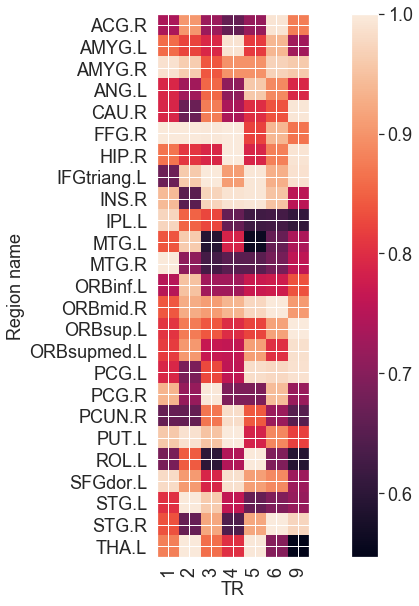

In [89]:
# Show the important regions. Importance threshold was set in the previous cell
sns.set(font_scale=3)  # crazy big
sns.set(rc={'figure.figsize':(11,8)})
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)

to_plot = regions_importance_portion[:,np.where(significant_trs<10)[0]].T

fig = plt.figure(figsize=(15, 10))
selected_regions = to_plot.max(axis=0)>importance_threshold
selected_regions = np.where(selected_regions)[0]

to_show = to_plot[:,selected_regions]
plt.imshow(to_show.T)
plt.xticks(np.arange(to_show.shape[0]), significant_trs, rotation=90)
plt.yticks(np.arange(to_show.shape[1]), region_names[selected_regions], rotation=0)
plt.xlabel('TR', size=18)
plt.ylabel('Region name', size=18)
plt.colorbar()

plt.show()


In [90]:
# Now calculate importance stability factor

actual_means = True # Actual means or bootstrap
ini_list = np.zeros(runs)
ini_list.fill(np.nan)
regions_importance_value_bootstrap_mean = np.zeros((region_names.shape[0], max_slc))
regions_importance_value_actual_mean = np.zeros((region_names.shape[0], max_slc))
ci = .95

for slc in range(max_slc):
    print('TR: ', slc, ', t_stat: ', model_shuffle_t_test[slc][0], ', p_val: ', model_shuffle_t_test[slc][1])
    d = regions_importance_portion[:,slc]    
    
    for reg_name in region_names:
        region_indx = np.where(region_names==reg_name)[0][0]
        v = regions_importance_values[slc][:,region_indx]
        s = regions_importance_selected[slc][:,region_indx]
        v = v[s==1]        
        regions_importance_value_actual_mean[region_indx, slc] = np.mean(v)
        
        boot_strapped = get_region_coef_distr(reg_name, ci, d[region_indx], abs(v))
        regions_importance_value_bootstrap_mean[region_indx, slc] = np.mean(boot_strapped)
    


TR:  0 , t_stat:  14.795826735823365 , p_val:  2.8848287613801477e-48
Region: ACG.L, ci: (0.1123, ci: 0.1281), bagged importance level: 0.1200 , importance stability factor: 0.8084
Region: ACG.R, ci: (0.1334, ci: 0.1531), bagged importance level: 0.1430 , importance stability factor: 0.7386
Region: AMYG.L, ci: (0.1364, ci: 0.1543), bagged importance level: 0.1447 , importance stability factor: 0.8592
Region: AMYG.R, ci: (0.3455, ci: 0.3683), bagged importance level: 0.3568 , importance stability factor: 0.9886
Region: ANG.L, ci: (0.1128, ci: 0.1286), bagged importance level: 0.1203 , importance stability factor: 0.7916
Region: ANG.R, ci: (0.1005, ci: 0.1162), bagged importance level: 0.1079 , importance stability factor: 0.6864
Region: CAU.L, ci: (0.1253, ci: 0.1451), bagged importance level: 0.1351 , importance stability factor: 0.7518
Region: CAU.R, ci: (0.1165, ci: 0.1325), bagged importance level: 0.1244 , importance stability factor: 0.7908
Region: CUN.L, ci: (0.1261, ci: 0.1458),

Region: MTG.L, ci: (0.4286, ci: 0.4635), bagged importance level: 0.4465 , importance stability factor: 0.9618
Region: MTG.R, ci: (0.1547, ci: 0.1783), bagged importance level: 0.1664 , importance stability factor: 0.7079
Region: ORBinf.L, ci: (0.3563, ci: 0.3852), bagged importance level: 0.3698 , importance stability factor: 0.9518
Region: ORBinf.R, ci: (0.1834, ci: 0.2109), bagged importance level: 0.1967 , importance stability factor: 0.7230
Region: ORBmid.L, ci: (0.1213, ci: 0.1413), bagged importance level: 0.1313 , importance stability factor: 0.7553
Region: ORBmid.R, ci: (0.2154, ci: 0.2351), bagged importance level: 0.2250 , importance stability factor: 0.9267
Region: ORBsup.L, ci: (0.2225, ci: 0.2486), bagged importance level: 0.2352 , importance stability factor: 0.8750
Region: ORBsup.R, ci: (0.0853, ci: 0.0987), bagged importance level: 0.0919 , importance stability factor: 0.6706
Region: ORBsupmed.L, ci: (0.2587, ci: 0.2869), bagged importance level: 0.2730 , importance st

Region: SPG.R, ci: (0.2674, ci: 0.2978), bagged importance level: 0.2824 , importance stability factor: 0.8363
Region: STG.L, ci: (0.3885, ci: 0.4212), bagged importance level: 0.4049 , importance stability factor: 0.9617
Region: STG.R, ci: (0.4690, ci: 0.5104), bagged importance level: 0.4901 , importance stability factor: 0.9220
Region: THA.L, ci: (0.3121, ci: 0.3458), bagged importance level: 0.3288 , importance stability factor: 0.8624
Region: THA.R, ci: (0.1392, ci: 0.1610), bagged importance level: 0.1498 , importance stability factor: 0.6899
TR:  3 , t_stat:  -31.036914574871027 , p_val:  1.1131503197110593e-189
Region: ACG.L, ci: (0.1287, ci: 0.1534), bagged importance level: 0.1405 , importance stability factor: 0.6418
Region: ACG.R, ci: (0.1530, ci: 0.1792), bagged importance level: 0.1652 , importance stability factor: 0.6646
Region: AMYG.L, ci: (0.4462, ci: 0.4736), bagged importance level: 0.4601 , importance stability factor: 0.9901
Region: AMYG.R, ci: (0.2195, ci: 0.2446

Region: IFGtriang.R, ci: (0.1973, ci: 0.2245), bagged importance level: 0.2110 , importance stability factor: 0.7843
Region: INS.L, ci: (0.1604, ci: 0.1834), bagged importance level: 0.1718 , importance stability factor: 0.7590
Region: INS.R, ci: (0.5811, ci: 0.6144), bagged importance level: 0.5979 , importance stability factor: 0.9933
Region: IPL.L, ci: (0.0920, ci: 0.1086), bagged importance level: 0.1002 , importance stability factor: 0.6235
Region: IPL.R, ci: (0.1577, ci: 0.1770), bagged importance level: 0.1673 , importance stability factor: 0.8168
Region: MTG.L, ci: (0.1368, ci: 0.1639), bagged importance level: 0.1500 , importance stability factor: 0.5618
Region: MTG.R, ci: (0.1565, ci: 0.1826), bagged importance level: 0.1695 , importance stability factor: 0.6532
Region: ORBinf.L, ci: (0.1186, ci: 0.1363), bagged importance level: 0.1271 , importance stability factor: 0.7731
Region: ORBinf.R, ci: (0.0923, ci: 0.1079), bagged importance level: 0.0999 , importance stability fact

Region: SFGdor.L, ci: (0.3939, ci: 0.4333), bagged importance level: 0.4136 , importance stability factor: 0.8886
Region: SFGdor.R, ci: (0.1011, ci: 0.1181), bagged importance level: 0.1094 , importance stability factor: 0.6082
Region: SFGmed.L, ci: (0.3369, ci: 0.3727), bagged importance level: 0.3542 , importance stability factor: 0.8814
Region: SFGmed.R, ci: (0.1843, ci: 0.2102), bagged importance level: 0.1975 , importance stability factor: 0.7521
Region: SPG.L, ci: (0.0891, ci: 0.1033), bagged importance level: 0.0957 , importance stability factor: 0.6959
Region: SPG.R, ci: (0.0959, ci: 0.1107), bagged importance level: 0.1032 , importance stability factor: 0.6819
Region: STG.L, ci: (0.1168, ci: 0.1364), bagged importance level: 0.1270 , importance stability factor: 0.6936
Region: STG.R, ci: (0.5988, ci: 0.6289), bagged importance level: 0.6142 , importance stability factor: 0.9991
Region: THA.L, ci: (0.1950, ci: 0.2257), bagged importance level: 0.2097 , importance stability fact

Region: HIP.L, ci: (0.3571, ci: 0.3919), bagged importance level: 0.3750 , importance stability factor: 0.8973
Region: HIP.R, ci: (0.0960, ci: 0.1099), bagged importance level: 0.1024 , importance stability factor: 0.7301
Region: IFGoperc.L, ci: (0.0720, ci: 0.0841), bagged importance level: 0.0780 , importance stability factor: 0.6987
Region: IFGoperc.R, ci: (0.0787, ci: 0.0940), bagged importance level: 0.0859 , importance stability factor: 0.6160
Region: IFGtriang.L, ci: (0.3361, ci: 0.3644), bagged importance level: 0.3501 , importance stability factor: 0.9148
Region: IFGtriang.R, ci: (0.1016, ci: 0.1165), bagged importance level: 0.1088 , importance stability factor: 0.7319
Region: INS.L, ci: (0.2834, ci: 0.3037), bagged importance level: 0.2932 , importance stability factor: 0.9730
Region: INS.R, ci: (0.1091, ci: 0.1275), bagged importance level: 0.1180 , importance stability factor: 0.7329
Region: IPL.L, ci: (0.0852, ci: 0.1044), bagged importance level: 0.0946 , importance stab

Region: PCUN.R, ci: (0.1822, ci: 0.2169), bagged importance level: 0.1992 , importance stability factor: 0.5822
Region: PUT.L, ci: (0.2687, ci: 0.2909), bagged importance level: 0.2796 , importance stability factor: 0.9554
Region: PUT.R, ci: (0.1272, ci: 0.1447), bagged importance level: 0.1357 , importance stability factor: 0.8024
Region: ROL.L, ci: (0.1952, ci: 0.2203), bagged importance level: 0.2073 , importance stability factor: 0.8136
Region: ROL.R, ci: (0.1473, ci: 0.1716), bagged importance level: 0.1592 , importance stability factor: 0.7109
Region: SFGdor.L, ci: (0.4932, ci: 0.5208), bagged importance level: 0.5067 , importance stability factor: 0.9951
Region: SFGdor.R, ci: (0.1366, ci: 0.1587), bagged importance level: 0.1475 , importance stability factor: 0.6490
Region: SFGmed.L, ci: (0.1602, ci: 0.1831), bagged importance level: 0.1707 , importance stability factor: 0.7409
Region: SFGmed.R, ci: (0.1375, ci: 0.1579), bagged importance level: 0.1478 , importance stability fac

Region: CAU.R, ci: (0.1899, ci: 0.2146), bagged importance level: 0.2021 , importance stability factor: 0.7976
Region: CUN.L, ci: (0.1835, ci: 0.2035), bagged importance level: 0.1935 , importance stability factor: 0.8894
Region: CUN.R, ci: (0.1143, ci: 0.1321), bagged importance level: 0.1229 , importance stability factor: 0.6643
Region: FFG.L, ci: (0.2153, ci: 0.2361), bagged importance level: 0.2253 , importance stability factor: 0.9181
Region: FFG.R, ci: (0.1247, ci: 0.1450), bagged importance level: 0.1347 , importance stability factor: 0.6778
Region: HIP.L, ci: (0.0976, ci: 0.1144), bagged importance level: 0.1059 , importance stability factor: 0.6667
Region: HIP.R, ci: (0.1254, ci: 0.1473), bagged importance level: 0.1363 , importance stability factor: 0.6263
Region: IFGoperc.L, ci: (0.1045, ci: 0.1212), bagged importance level: 0.1124 , importance stability factor: 0.7062
Region: IFGoperc.R, ci: (0.2679, ci: 0.3028), bagged importance level: 0.2846 , importance stability factor

Region: ORBsupmed.L, ci: (0.1463, ci: 0.1729), bagged importance level: 0.1592 , importance stability factor: 0.5967
Region: ORBsupmed.R, ci: (0.1463, ci: 0.1711), bagged importance level: 0.1585 , importance stability factor: 0.6533
Region: PCG.L, ci: (0.1028, ci: 0.1191), bagged importance level: 0.1108 , importance stability factor: 0.7841
Region: PCG.R, ci: (0.0959, ci: 0.1121), bagged importance level: 0.1030 , importance stability factor: 0.6883
Region: PCUN.L, ci: (0.1955, ci: 0.2273), bagged importance level: 0.2107 , importance stability factor: 0.6593
Region: PCUN.R, ci: (0.1663, ci: 0.1962), bagged importance level: 0.1804 , importance stability factor: 0.6033
Region: PUT.L, ci: (0.1591, ci: 0.1804), bagged importance level: 0.1693 , importance stability factor: 0.7763
Region: PUT.R, ci: (0.0920, ci: 0.1049), bagged importance level: 0.0983 , importance stability factor: 0.7350
Region: ROL.L, ci: (0.1132, ci: 0.1306), bagged importance level: 0.1218 , importance stability fa

Region: AMYG.L, ci: (0.1520, ci: 0.1750), bagged importance level: 0.1634 , importance stability factor: 0.7454
Region: AMYG.R, ci: (0.0752, ci: 0.0863), bagged importance level: 0.0807 , importance stability factor: 0.8209
Region: ANG.L, ci: (0.0871, ci: 0.1007), bagged importance level: 0.0939 , importance stability factor: 0.7808
Region: ANG.R, ci: (0.1667, ci: 0.1875), bagged importance level: 0.1768 , importance stability factor: 0.8687
Region: CAU.L, ci: (0.2929, ci: 0.3179), bagged importance level: 0.3055 , importance stability factor: 0.9602
Region: CAU.R, ci: (0.1287, ci: 0.1484), bagged importance level: 0.1385 , importance stability factor: 0.7658
Region: CUN.L, ci: (0.1189, ci: 0.1376), bagged importance level: 0.1281 , importance stability factor: 0.7046
Region: CUN.R, ci: (0.1272, ci: 0.1461), bagged importance level: 0.1365 , importance stability factor: 0.6845
Region: FFG.L, ci: (0.1287, ci: 0.1471), bagged importance level: 0.1372 , importance stability factor: 0.7130

Region: ORBinf.R, ci: (0.0915, ci: 0.1067), bagged importance level: 0.0985 , importance stability factor: 0.6906
Region: ORBmid.L, ci: (0.2149, ci: 0.2320), bagged importance level: 0.2231 , importance stability factor: 0.9380
Region: ORBmid.R, ci: (0.1022, ci: 0.1169), bagged importance level: 0.1087 , importance stability factor: 0.7465
Region: ORBsup.L, ci: (0.1066, ci: 0.1217), bagged importance level: 0.1136 , importance stability factor: 0.7780
Region: ORBsup.R, ci: (0.1845, ci: 0.2009), bagged importance level: 0.1924 , importance stability factor: 0.9501
Region: ORBsupmed.L, ci: (0.0924, ci: 0.1109), bagged importance level: 0.1013 , importance stability factor: 0.5469
Region: ORBsupmed.R, ci: (0.1677, ci: 0.1961), bagged importance level: 0.1815 , importance stability factor: 0.6547
Region: PCG.L, ci: (0.2101, ci: 0.2315), bagged importance level: 0.2203 , importance stability factor: 0.9289
Region: PCG.R, ci: (0.1159, ci: 0.1346), bagged importance level: 0.1248 , importance

Region: THA.L, ci: (0.1019, ci: 0.1197), bagged importance level: 0.1109 , importance stability factor: 0.6690
Region: THA.R, ci: (0.2321, ci: 0.2553), bagged importance level: 0.2430 , importance stability factor: 0.8980
TR:  16 , t_stat:  2.5605077344102933 , p_val:  0.010488351229884422
Region: ACG.L, ci: (0.1481, ci: 0.1728), bagged importance level: 0.1607 , importance stability factor: 0.6475
Region: ACG.R, ci: (0.3492, ci: 0.3787), bagged importance level: 0.3634 , importance stability factor: 0.9588
Region: AMYG.L, ci: (0.1444, ci: 0.1643), bagged importance level: 0.1540 , importance stability factor: 0.7662
Region: AMYG.R, ci: (0.4273, ci: 0.4522), bagged importance level: 0.4394 , importance stability factor: 0.9980
Region: ANG.L, ci: (0.2596, ci: 0.2829), bagged importance level: 0.2707 , importance stability factor: 0.9267
Region: ANG.R, ci: (0.2504, ci: 0.2763), bagged importance level: 0.2642 , importance stability factor: 0.8990
Region: CAU.L, ci: (0.1067, ci: 0.1229), 

Region: IPL.L, ci: (0.1711, ci: 0.1962), bagged importance level: 0.1835 , importance stability factor: 0.7117
Region: IPL.R, ci: (0.3664, ci: 0.4030), bagged importance level: 0.3843 , importance stability factor: 0.9415
Region: MTG.L, ci: (0.2435, ci: 0.2735), bagged importance level: 0.2589 , importance stability factor: 0.8308
Region: MTG.R, ci: (0.2637, ci: 0.2939), bagged importance level: 0.2786 , importance stability factor: 0.8328
Region: ORBinf.L, ci: (0.5420, ci: 0.5814), bagged importance level: 0.5622 , importance stability factor: 0.9614
Region: ORBinf.R, ci: (0.1529, ci: 0.1713), bagged importance level: 0.1622 , importance stability factor: 0.8495
Region: ORBmid.L, ci: (0.1617, ci: 0.1812), bagged importance level: 0.1712 , importance stability factor: 0.8332
Region: ORBmid.R, ci: (0.1234, ci: 0.1400), bagged importance level: 0.1319 , importance stability factor: 0.8355
Region: ORBsup.L, ci: (0.2362, ci: 0.2646), bagged importance level: 0.2505 , importance stability f

TR:  1 , t_stat:  -19.778953550776126 , p_val:  3.792053654307873e-83
Region: AMYG.R, ci: (0.3495, ci: 0.3758), bagged importance level: 0.3626 , importance stability factor: 0.9642
Region: FFG.R, ci: (0.7823, ci: 0.8180), bagged importance level: 0.7997 , importance stability factor: 0.9980
Region: IFGtriang.L, ci: (0.4609, ci: 0.4981), bagged importance level: 0.4791 , importance stability factor: 0.9609
Region: MTG.L, ci: (0.4289, ci: 0.4627), bagged importance level: 0.4465 , importance stability factor: 0.9618
Region: ORBinf.L, ci: (0.3563, ci: 0.3835), bagged importance level: 0.3699 , importance stability factor: 0.9518
Region: PUT.L, ci: (0.3924, ci: 0.4175), bagged importance level: 0.4047 , importance stability factor: 0.9878
Region: STG.L, ci: (0.7113, ci: 0.7590), bagged importance level: 0.7352 , importance stability factor: 0.9981
Region: THA.L, ci: (0.9250, ci: 0.9702), bagged importance level: 0.9450 , importance stability factor: 0.9971


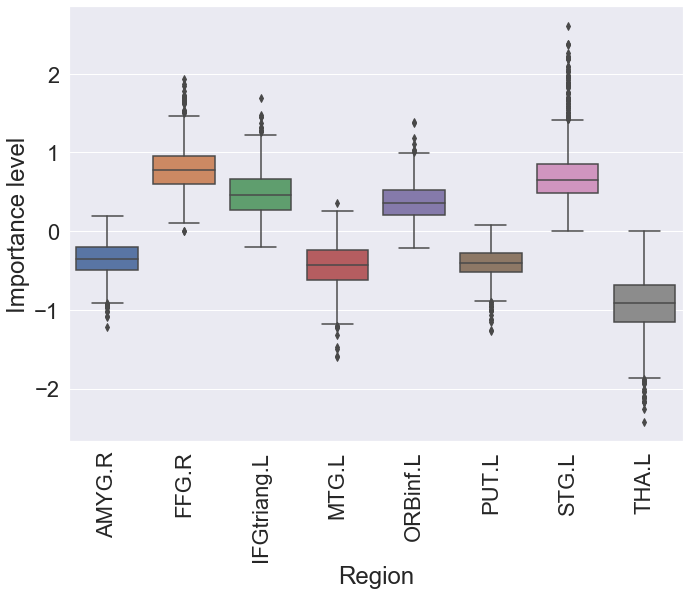

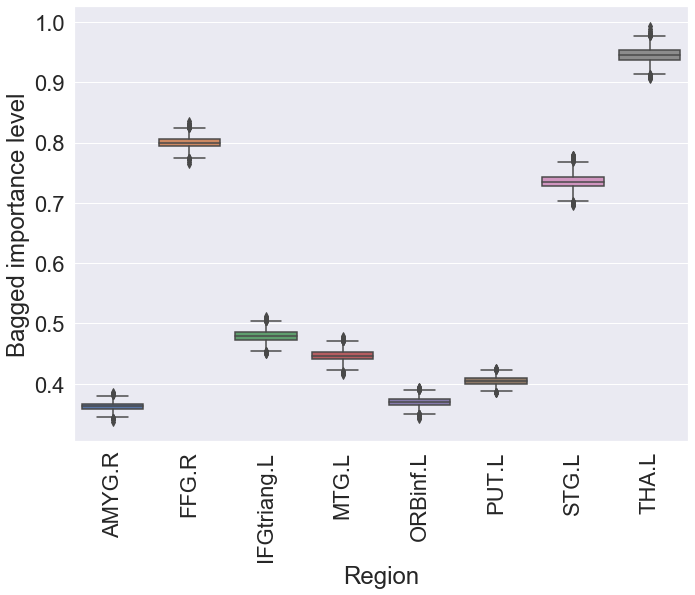

TR:  2 , t_stat:  -6.847558585196648 , p_val:  8.659919186927418e-12
Region: FFG.R, ci: (0.6310, ci: 0.6640), bagged importance level: 0.6469 , importance stability factor: 0.9959
Region: IFGtriang.L, ci: (0.9010, ci: 0.9419), bagged importance level: 0.9208 , importance stability factor: 0.9971
Region: INS.R, ci: (0.5651, ci: 0.6031), bagged importance level: 0.5846 , importance stability factor: 0.9719
Region: PCG.R, ci: (0.9797, ci: 1.0189), bagged importance level: 0.9996 , importance stability factor: 0.9950
Region: PUT.L, ci: (0.4813, ci: 0.5244), bagged importance level: 0.5024 , importance stability factor: 0.9523
Region: STG.L, ci: (0.3899, ci: 0.4206), bagged importance level: 0.4050 , importance stability factor: 0.9617


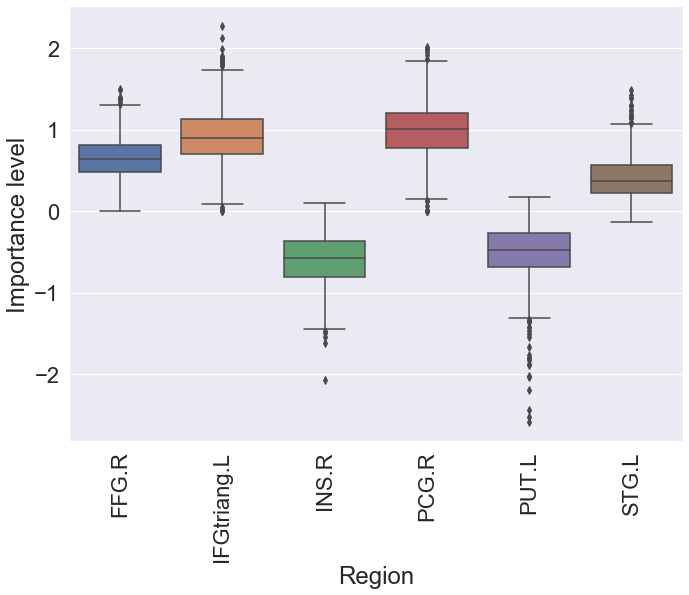

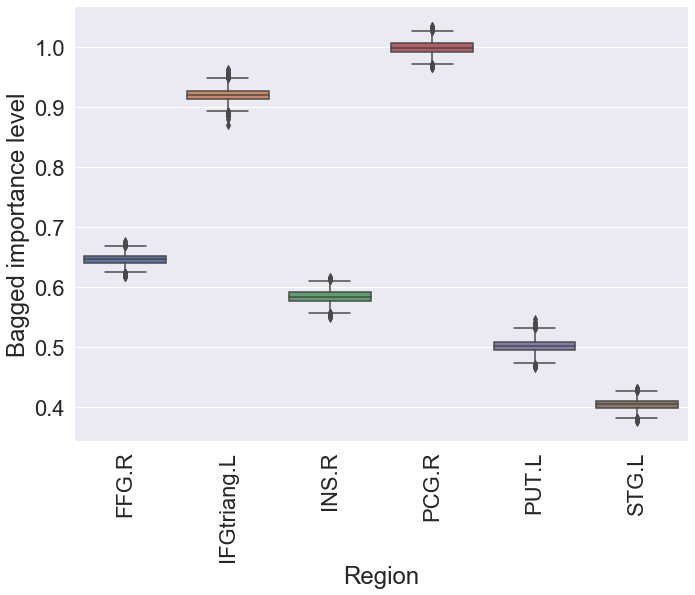

TR:  3 , t_stat:  -31.036914574871027 , p_val:  1.1131503197110593e-189
Region: AMYG.L, ci: (0.4453, ci: 0.4737), bagged importance level: 0.4602 , importance stability factor: 0.9901
Region: FFG.R, ci: (0.9328, ci: 0.9713), bagged importance level: 0.9516 , importance stability factor: 0.9990
Region: HIP.R, ci: (0.7781, ci: 0.8161), bagged importance level: 0.7976 , importance stability factor: 1.0000
Region: INS.R, ci: (0.7776, ci: 0.8190), bagged importance level: 0.7983 , importance stability factor: 0.9910
Region: PCUN.R, ci: (1.0678, ci: 1.1281), bagged importance level: 1.0981 , importance stability factor: 0.9828
Region: PUT.L, ci: (1.7085, ci: 1.7603), bagged importance level: 1.7335 , importance stability factor: 1.0000
Region: SFGdor.L, ci: (0.7591, ci: 0.8017), bagged importance level: 0.7802 , importance stability factor: 0.9862


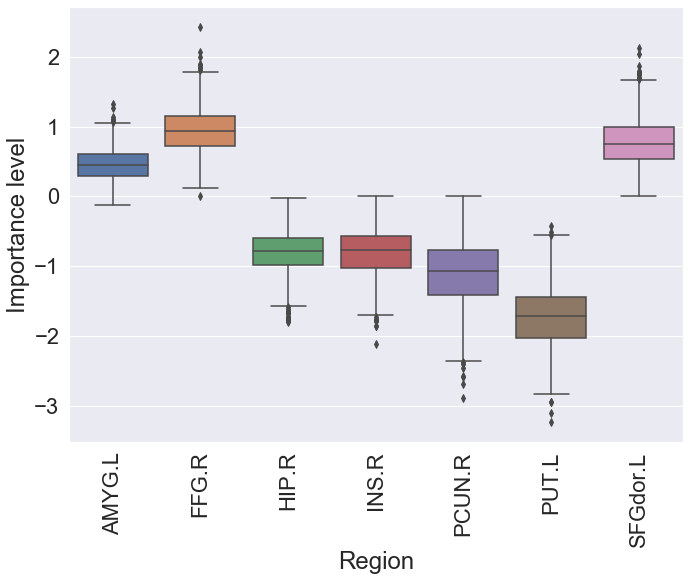

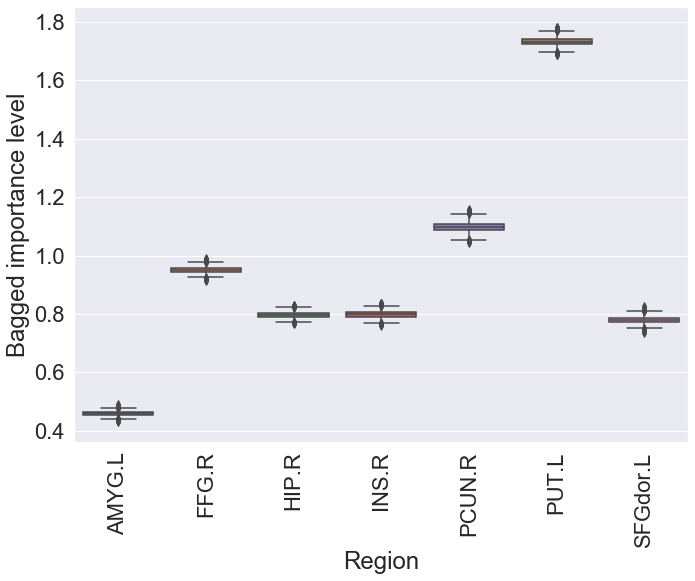

TR:  4 , t_stat:  -7.105886382153604 , p_val:  1.4090406334803677e-12
Region: ANG.L, ci: (0.3153, ci: 0.3414), bagged importance level: 0.3275 , importance stability factor: 0.9580
Region: IFGtriang.L, ci: (0.6077, ci: 0.6392), bagged importance level: 0.6243 , importance stability factor: 0.9940
Region: INS.R, ci: (0.5817, ci: 0.6138), bagged importance level: 0.5979 , importance stability factor: 0.9933
Region: ORBmid.R, ci: (0.2989, ci: 0.3203), bagged importance level: 0.3094 , importance stability factor: 0.9759
Region: PCG.L, ci: (0.5805, ci: 0.6140), bagged importance level: 0.5976 , importance stability factor: 0.9829
Region: ROL.L, ci: (0.6260, ci: 0.6571), bagged importance level: 0.6416 , importance stability factor: 0.9970
Region: THA.L, ci: (0.7158, ci: 0.7591), bagged importance level: 0.7371 , importance stability factor: 0.9959


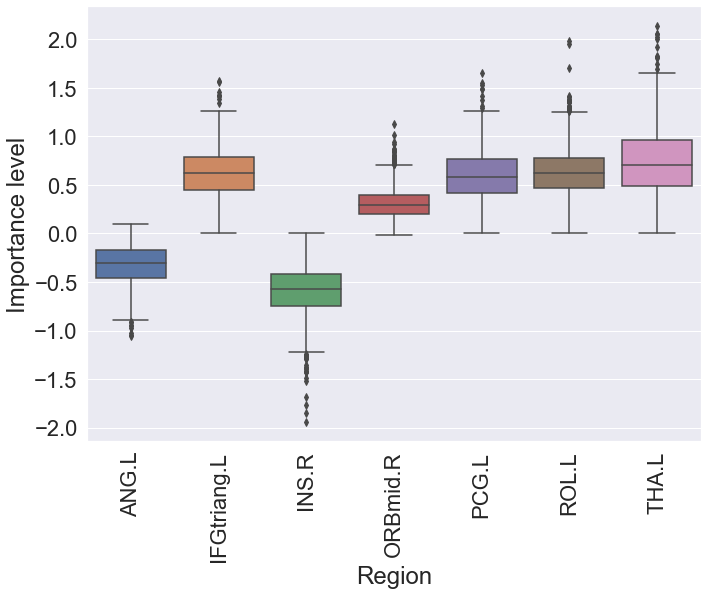

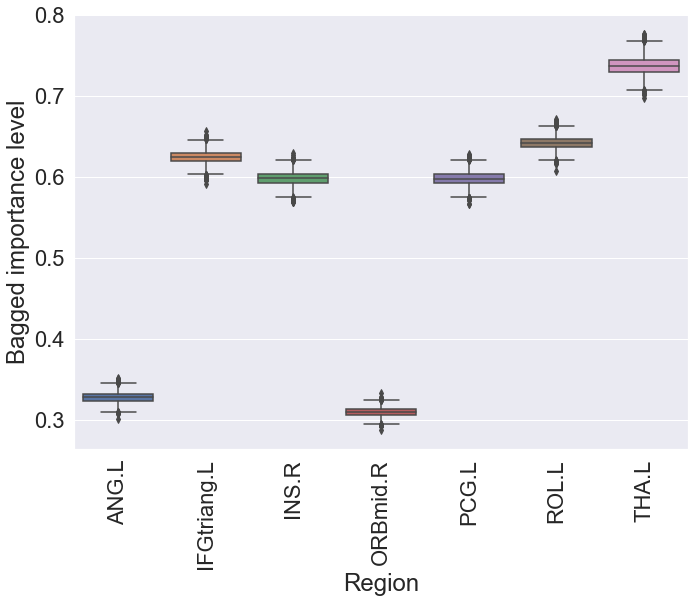

TR:  5 , t_stat:  -10.6957930659808 , p_val:  2.41126367916366e-26
Region: ACG.R, ci: (0.6862, ci: 0.7294), bagged importance level: 0.7082 , importance stability factor: 0.9919
Region: AMYG.R, ci: (0.4353, ci: 0.4669), bagged importance level: 0.4507 , importance stability factor: 0.9711
Region: INS.R, ci: (0.3453, ci: 0.3733), bagged importance level: 0.3592 , importance stability factor: 0.9524
Region: ORBmid.R, ci: (0.5668, ci: 0.5991), bagged importance level: 0.5826 , importance stability factor: 0.9981
Region: PCG.L, ci: (0.5444, ci: 0.5774), bagged importance level: 0.5608 , importance stability factor: 0.9772
Region: STG.R, ci: (0.5991, ci: 0.6288), bagged importance level: 0.6141 , importance stability factor: 0.9991


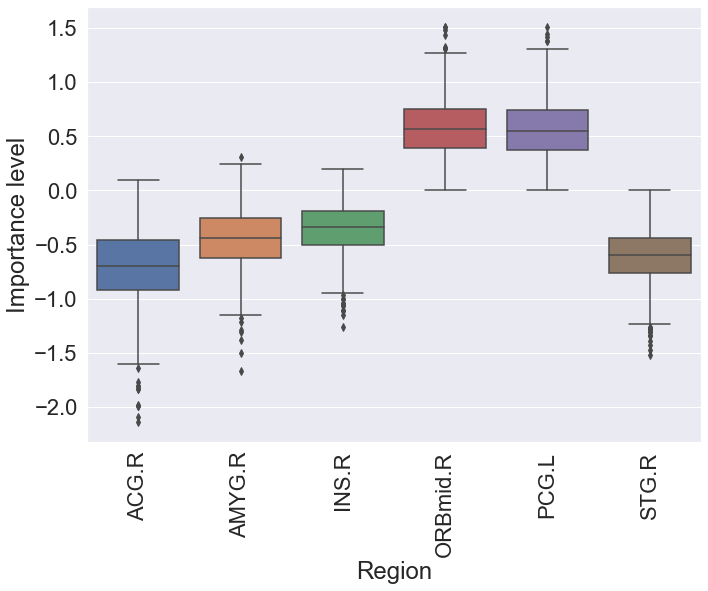

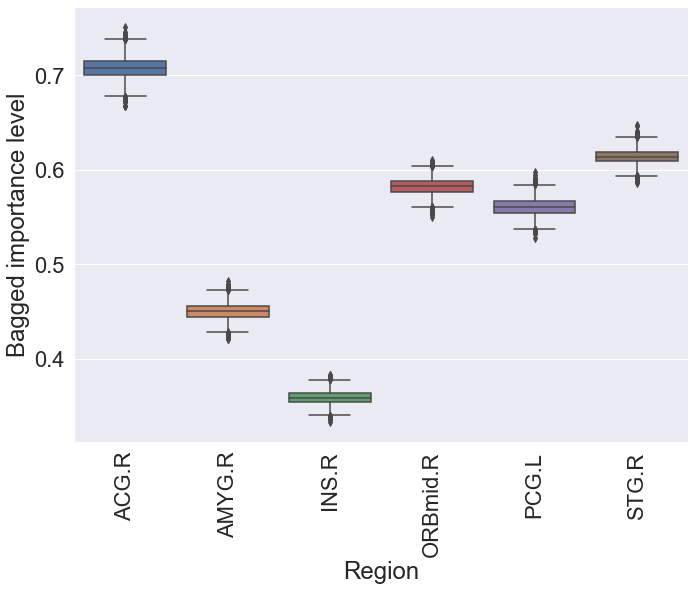

TR:  6 , t_stat:  -17.166447822943006 , p_val:  8.694579182625793e-64
Region: AMYG.R, ci: (0.3774, ci: 0.4065), bagged importance level: 0.3912 , importance stability factor: 0.9610
Region: CAU.R, ci: (0.6582, ci: 0.6966), bagged importance level: 0.6766 , importance stability factor: 0.9940
Region: HIP.R, ci: (0.4277, ci: 0.4531), bagged importance level: 0.4402 , importance stability factor: 0.9921
Region: IFGtriang.L, ci: (0.5198, ci: 0.5539), bagged importance level: 0.5363 , importance stability factor: 0.9892
Region: ORBsup.L, ci: (0.7557, ci: 0.7934), bagged importance level: 0.7739 , importance stability factor: 1.0000
Region: ORBsupmed.L, ci: (0.5070, ci: 0.5392), bagged importance level: 0.5230 , importance stability factor: 0.9860
Region: PCG.L, ci: (0.5168, ci: 0.5465), bagged importance level: 0.5315 , importance stability factor: 0.9889
Region: STG.R, ci: (0.4024, ci: 0.4299), bagged importance level: 0.4161 , importance stability factor: 0.9747


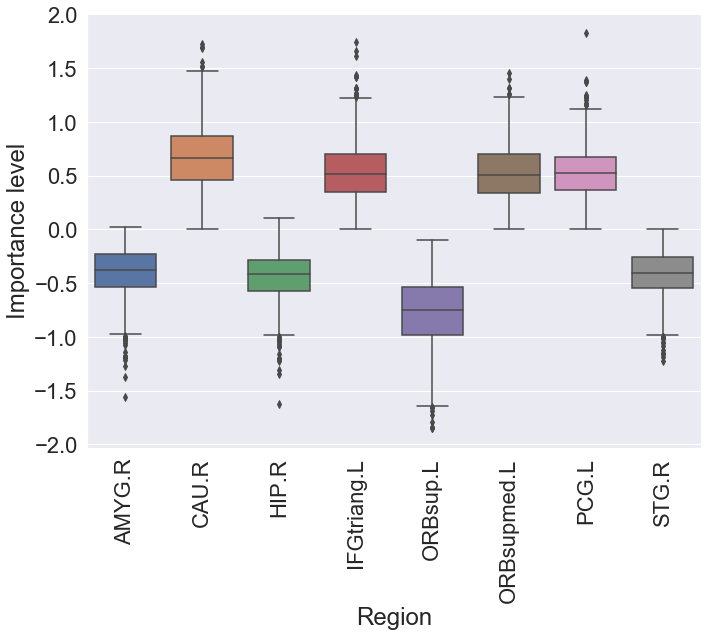

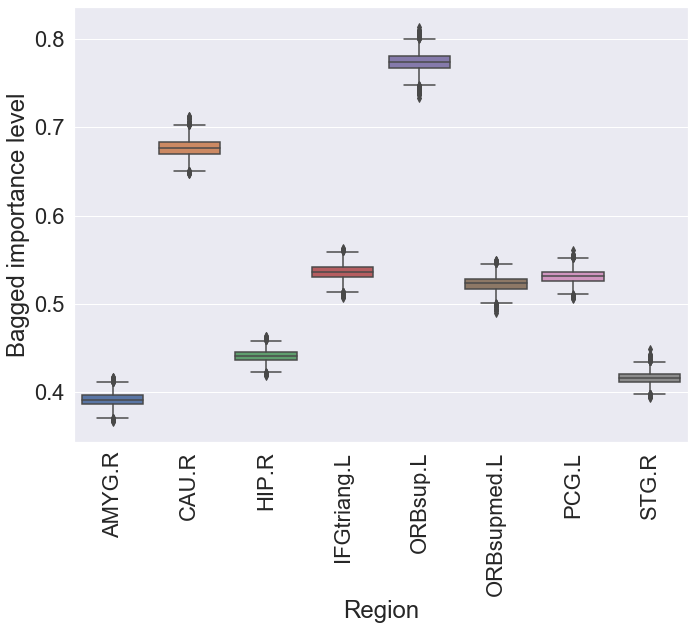

TR:  9 , t_stat:  -6.948696464015072 , p_val:  4.2858548347455644e-12
Region: IFGtriang.R, ci: (0.5028, ci: 0.5338), bagged importance level: 0.5178 , importance stability factor: 0.9875
Region: PCG.R, ci: (0.7071, ci: 0.7378), bagged importance level: 0.7228 , importance stability factor: 0.9990
Region: SFGdor.L, ci: (0.6507, ci: 0.6887), bagged importance level: 0.6695 , importance stability factor: 0.9897
Region: STG.L, ci: (0.5417, ci: 0.5731), bagged importance level: 0.5574 , importance stability factor: 0.9830
Region: THA.R, ci: (0.6875, ci: 0.7275), bagged importance level: 0.7071 , importance stability factor: 0.9862


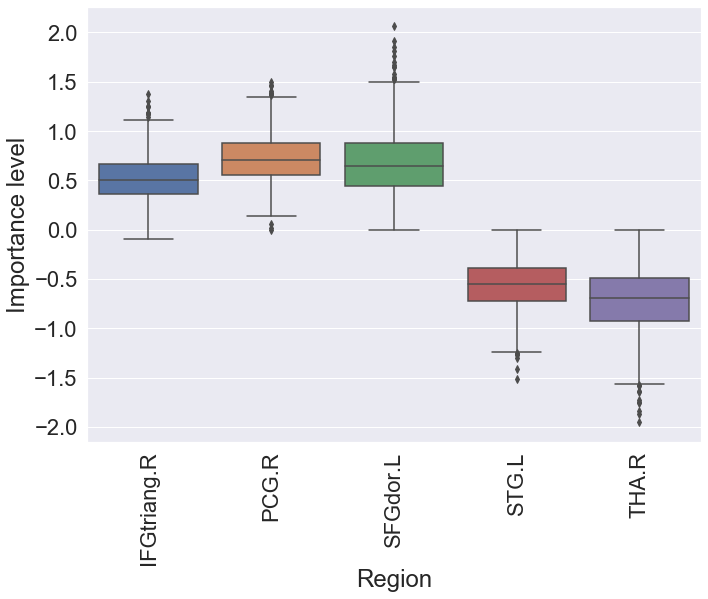

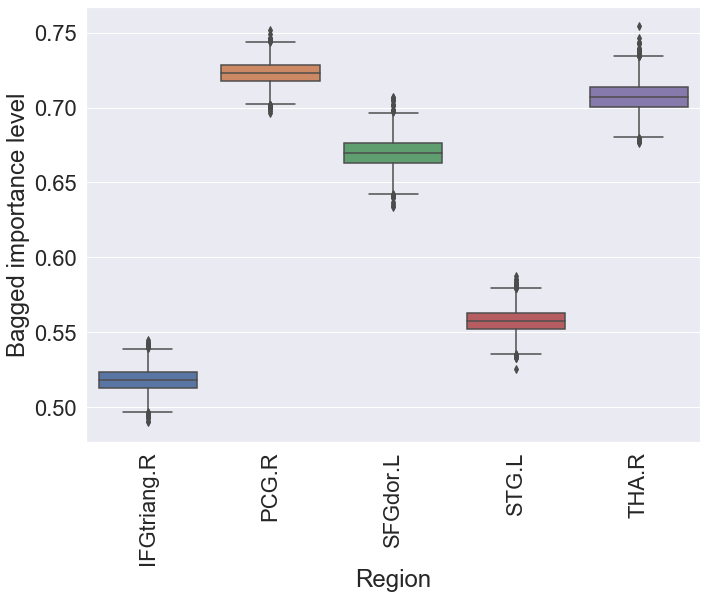

In [91]:
# Visualize importance level (not reliable) and bagged importance level (reliable)

actual_means = True # Actual means or bootstrap
ini_list = np.zeros(runs)
ini_list.fill(np.nan)

for slc in significant_trs[significant_trs<10]:
    print('TR: ', slc, ', t_stat: ', model_shuffle_t_test[slc][0], ', p_val: ', model_shuffle_t_test[slc][1])
    d = regions_importance_portion[:,slc]
    
    regions_importance_value_means = pd.DataFrame()
    regions_importance_value_actual = pd.DataFrame()
    
    for reg_name in region_names[d>importance_threshold]:
        region_indx = np.where(region_names==reg_name)[0][0]
        v = regions_importance_values[slc][:,region_indx]
        s = regions_importance_selected[slc][:,region_indx]
        v = v[s==1]        
        regions_importance_value_actual[reg_name] = ini_list
        regions_importance_value_actual[reg_name][:v.shape[0]] = (v)
        
        boot_strapped = get_region_coef_distr(reg_name, importance_threshold, d[region_indx], abs(v))
        regions_importance_value_means[reg_name] = boot_strapped
    
    regions_importance_value_actual.dropna(inplace=True)

    sns.set(font_scale=2)
    sns.boxplot(x='Region', y='Importance level', 
                data=regions_importance_value_actual.melt(value_name='Importance level', var_name='Region'))
    
    plt.xticks(rotation=90)
    plt.show()
    

    sns.set(font_scale=2)
    sns.boxplot(x='Region', y='Bagged importance level', 
                data=regions_importance_value_means.melt(value_name='Bagged importance level', var_name='Region'))
    
    plt.xticks(rotation=90)
    plt.show()

In [92]:
# Visualize Importance stability factor and bagged importance level
import networkx as nx
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
    

def get_linear_interp(values, mi, ma):
    min_s = min(values)
    max_s = max(values)
    s_values = ((ma-mi)/(max_s-min_s))*(values-min_s)+mi
    return s_values

def brain_pos(G, reg_cords):
    min_pos_x = 10000
    max_pos_x = -10000
    min_pos_y = 10000
    max_pos_y = -10000
    
    pos = dict()
    for r in np.asarray(G.nodes):
        region_indx = np.where(reg_cords[:,0]==r)[0][0]
        [x, y] = np.double(reg_cords[region_indx, [1,2]])
        pos[r] = [x, y]
        
    for r in range(reg_cords.shape[0]):
        [x, y] = np.double(reg_cords[r, [1,2]])
        
        min_pos_x = min([min_pos_x, x])
        min_pos_y = min([min_pos_y, y])
        max_pos_x = max([max_pos_x, x])
        max_pos_y = max([max_pos_y, y])
    
    fig = plt.figure(figsize=(18, 15))
    ax = fig.add_subplot(111)
    img = plt.imread('brain_image.png')
    shift_x = 20
    shift_y = 20
    ax.imshow(img, extent=[min_pos_x-shift_x, max_pos_x+shift_x, min_pos_y-shift_y, max_pos_y+shift_y])
    
    return pos, min_pos_x, min_pos_y, max_pos_x, max_pos_y, fig

# @interact(slc=(0, 17))
def show_importance_brain(slc, node_size_org, node_color_org, title, reg_cords, emphasise=1.0): 
    region_names = reg_cords[:,0]
    
    node_size = np.floor(np.power(get_linear_interp(node_size_org, 0., 1.0), emphasise)*3000)
    node_color = np.floor(np.power(get_linear_interp(node_color_org, 0., 1.0), emphasise)*1000)
    
    node_size = np.append(node_size, 3000*.3)    
    node_size = np.append(node_size, 3000*.5)
    node_size = np.append(node_size, 3000*.9)

    node_color = np.append(node_color, 1000*0.7)
    node_color = np.append(node_color, 1000*0.7)
    node_color = np.append(node_color, 1000*0.7)
    
    G = nx.Graph()
    
    for r in region_names:
        G.add_node(r)
        
    pos, min_pos_x, min_pos_y, max_pos_x, max_pos_y, fig = brain_pos(G, reg_cords)
    
    G.add_node('~30%')
    pos['~30%'] = [min_pos_x-15, max_pos_y]    
    
    G.add_node('~50%')
    pos['~50%'] = [min_pos_x-6, max_pos_y]
    
    G.add_node('~90%')
    pos['~90%'] = [min_pos_x+5, max_pos_y]    
    
    
    colors=node_color
    cmap=plt.cm.autumn_r
    vmin = min(colors)
    vmax = max(colors)
    nx.draw(G, with_labels=False, 
            node_size=node_size, edgecolors = 'k', 
            node_shape="o", alpha=.9, node_color=colors, vmin=vmin, vmax=vmax, 
                font_size=10, font_color="black", font_weight="bold", linewidth = 4,
                width=2, pos=pos, cmap=cmap)
    
    left, right = plt.xlim()
    bottom, top = plt.ylim()
    
    plt.text(left, top-7*(top-bottom)/100, 'Importance stability factor', fontsize=14)
    
    pos_higher = pos
    
    
    nx.draw_networkx_labels(G, pos_higher)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    hndl = plt.colorbar(sm)
    hndl.set_label('Bagged importance level', size=16)
    hndl.ax.tick_params(labelsize=14)


    plt.title(title, fontsize=24)
    
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return data


C:\Users\reza.bonyadi\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


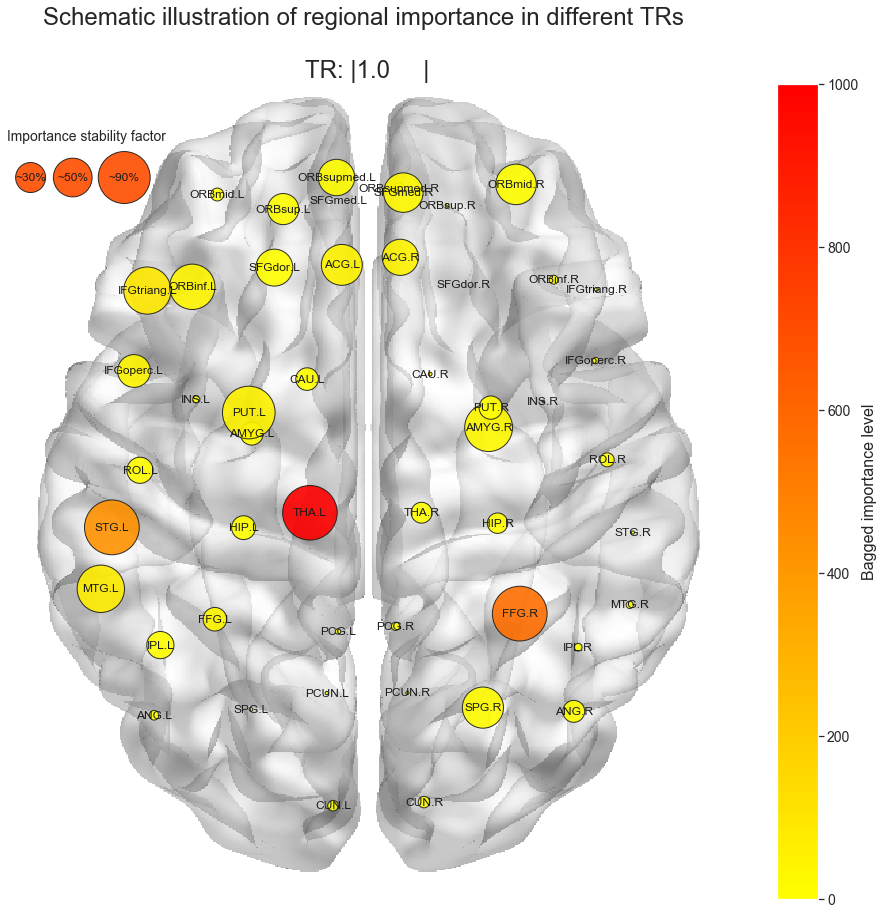

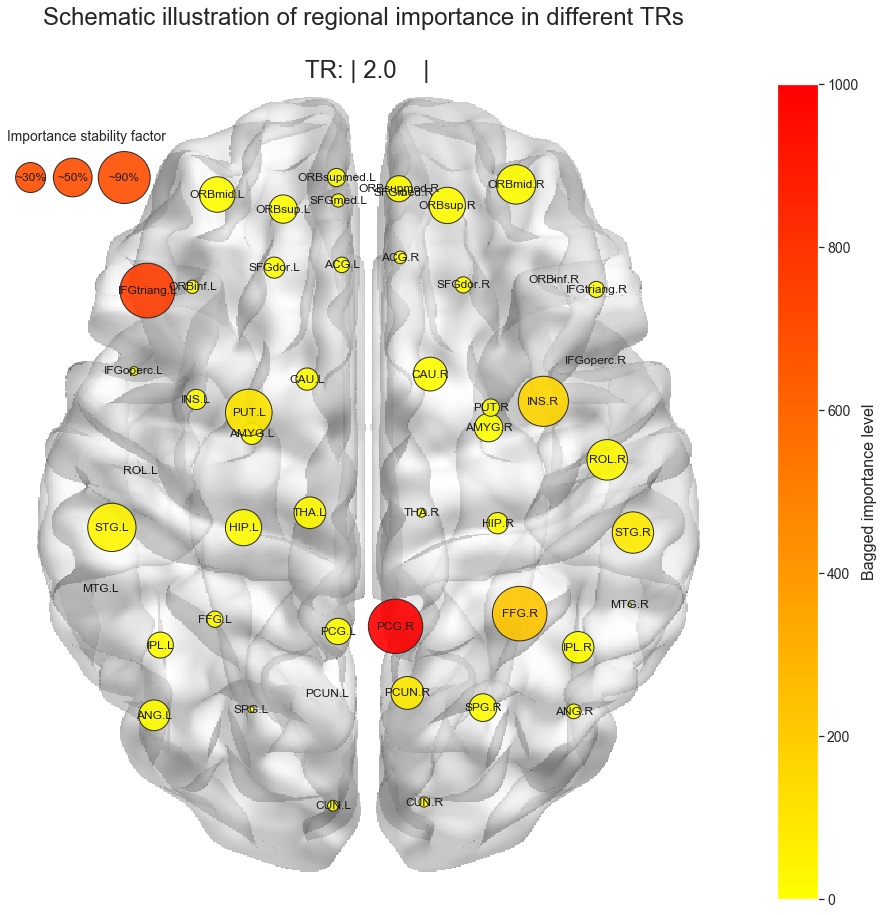

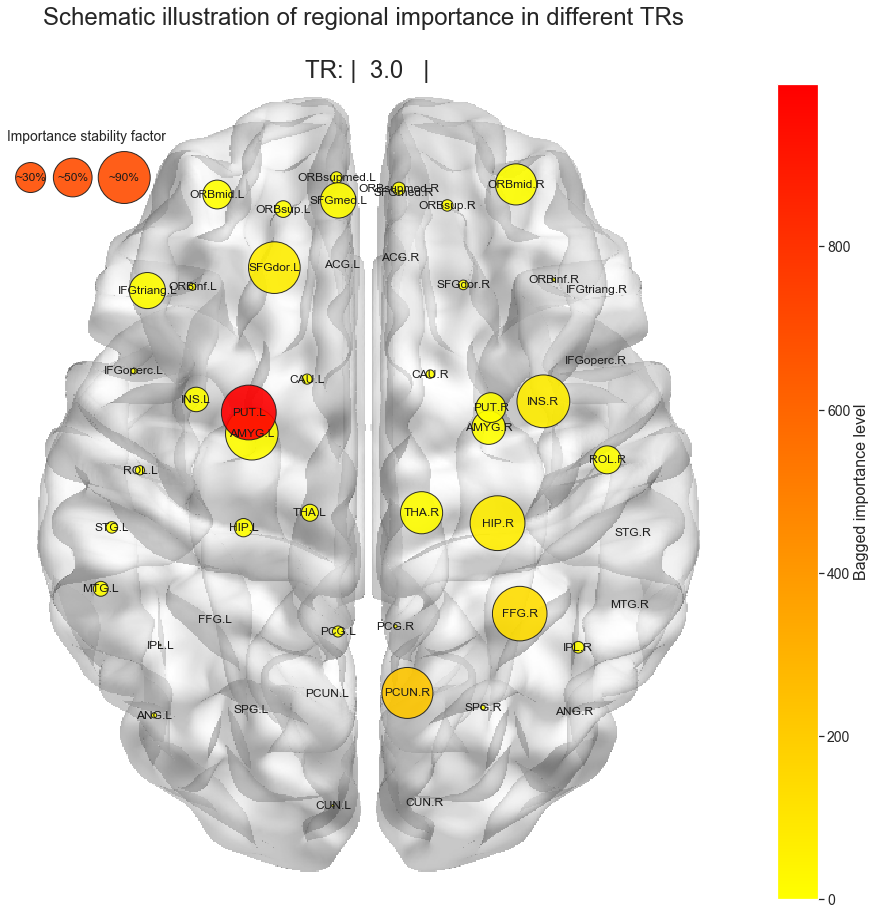

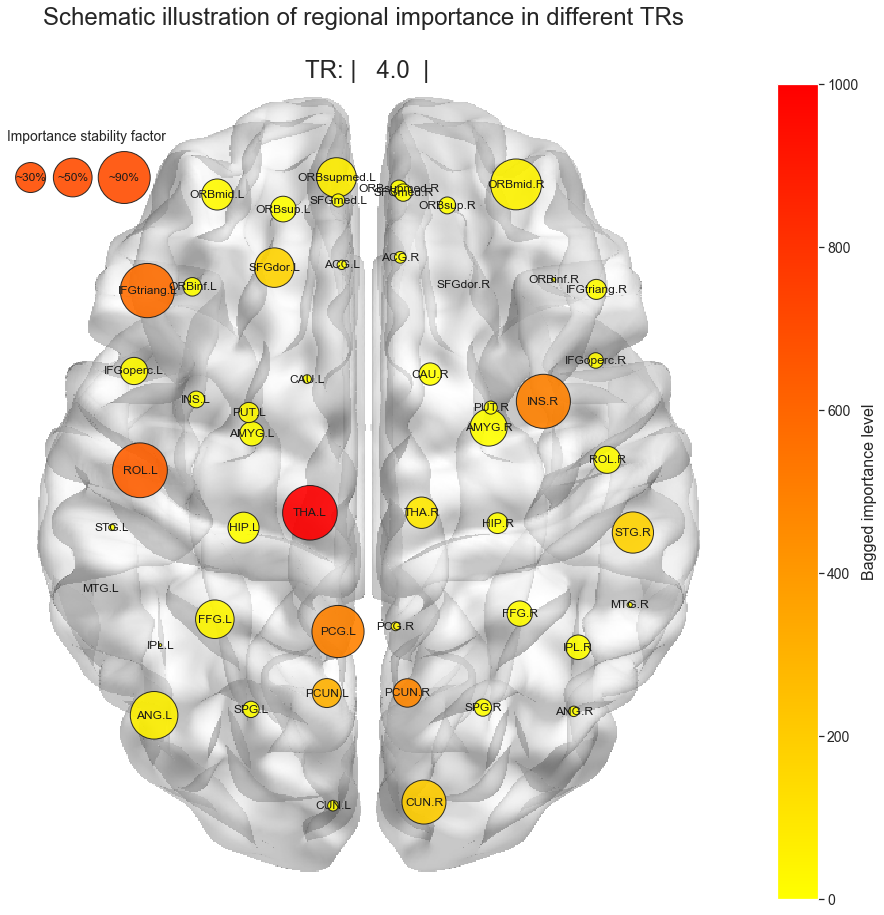

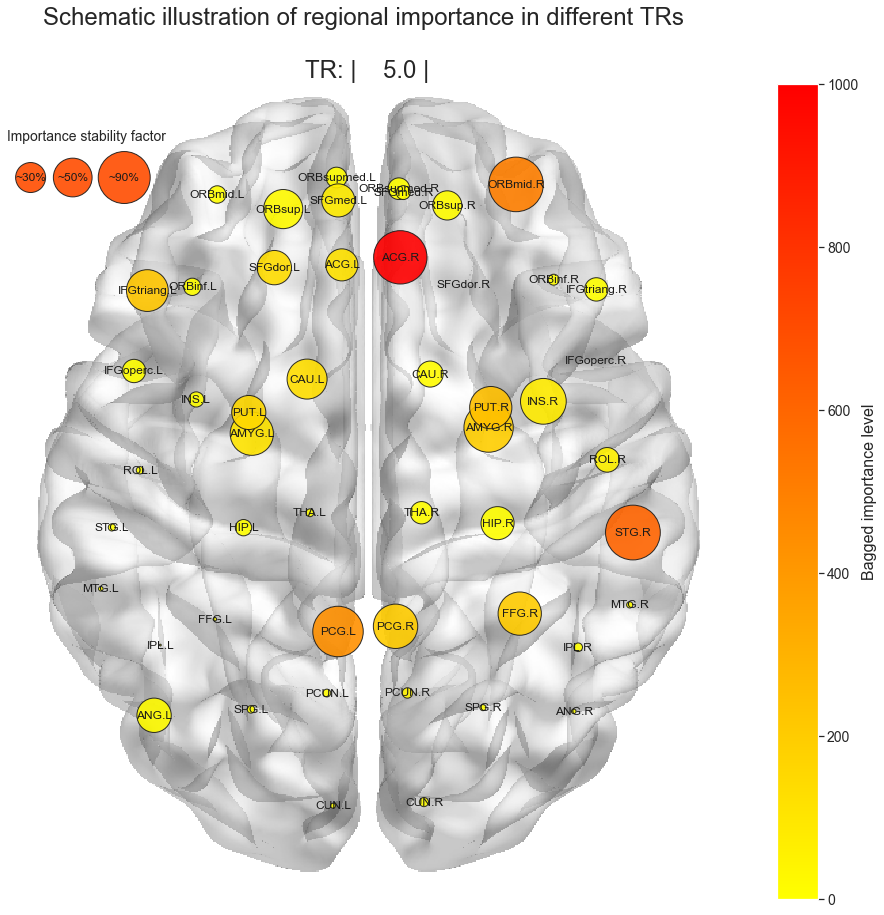

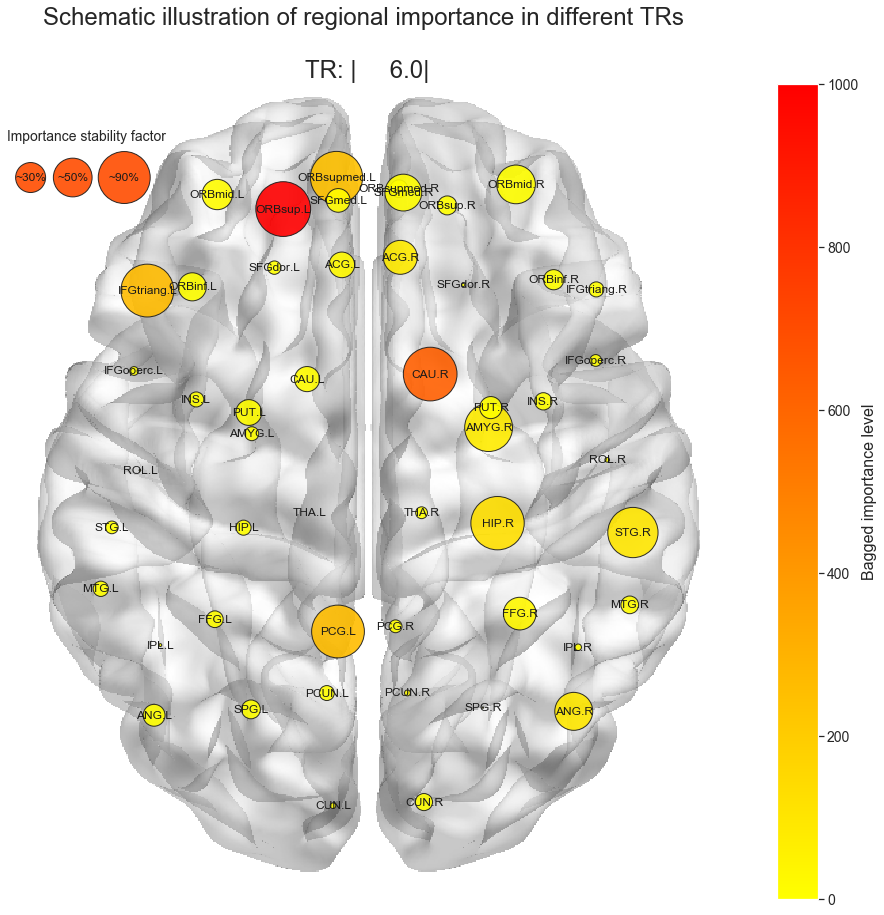

In [93]:
# Visualize bagged importance level and importance stability factor. It also does interpolation to make a visually  
# appealing gif file. Not used in the journal (just for illustration)

from scipy import interpolate

images = []
n = 7 # Resolution to interpolate
save_gif = False
# gif_name = 'importance_int_38_em_3.gif'
gif_name = 'importance_int_30_em_3.gif'


# Time TR to include [mi, ma]
mi = 1
ma = 7

regions_importance_portion_int = np.zeros((regions_importance_portion.shape[0], n))
regions_importance_value_bootstrap_mea_int = np.zeros((regions_importance_portion.shape[0], n))

xs = np.linspace(mi, ma, n, endpoint=True)
x = np.arange(0, max_slc)

for r in range(regions_importance_portion.shape[0]):
    y = regions_importance_portion[r,:]
    f = interpolate.interp1d(x, y)
    regions_importance_portion_int[r, :] = f(xs)
    
    y = regions_importance_value_bootstrap_mean[r,:]
    f = interpolate.interp1d(x, y)
    regions_importance_value_bootstrap_mea_int[r, :] = f(xs)

slc=0
while (xs[slc] < mi):
    slc+=1
mi_slc = slc
while (xs[slc] < ma):
    slc+=1
ma_slc = slc
fixed_title = 'Schematic illustration of regional importance in different TRs \n \n'
for slc in range(mi_slc, ma_slc):
    sizes = regions_importance_portion_int[:,slc]
    colors = regions_importance_value_bootstrap_mea_int[:,slc]
    
    t = ((ma_slc-mi_slc)*[' '])
    t[slc-mi_slc] = str(np.floor(xs[slc]))
    title = ''.join(t)
    title = ''.join([fixed_title, 'TR: |', title, '|'])
    
    images.append(show_importance_brain(slc, sizes, colors, title, reg_cords, emphasise=3))
    slc+=1
    
if save_gif:
    imageio.mimsave(gif_name, images, fps=4)

# Local connectivity (Markov Random Field)

In [94]:
# !pip install python-louvain

In [95]:
# Some functions for visualizing graphs

import networkx as nx
from community import community_louvain

def circ_layout(G, values):
    degs = 360/len(np.unique(values))
    pos = dict()
    r = 0.5
    int_r = 0.2
    node_degress = np.double(np.asarray(G.degree)[:,1])
    
    for i in np.unique(values):
        indx = np.where(i==values)
        nodes = np.asarray(G.nodes)[indx]
        node_degress_c = node_degress[indx]

        deg = i*degs
        c = [r*np.sin(deg*np.pi/180), r*np.cos(deg*np.pi/180)]

        int_degs = 360/len(nodes)
        indx = 0

        for j in nodes:
            per = (np.random.rand(2)-0.5)*.1
            int_deg = indx*int_degs
            p = [int_r*np.sin(int_deg*np.pi/180)+c[0]+per[0], int_r*np.cos(int_deg*np.pi/180)+c[1]+per[1]]
            pos[j] = p
            indx += 1
    return pos
        
def get_connectivity_full(region_names, values, sel):
    cnn = np.zeros((region_names.shape[0], region_names.shape[0]))
    op = np.zeros((region_names.shape[0], region_names.shape[0]))
    from_list = []
    to_list = []

    vs = values 
    for i in range(vs.shape[0]): # For all trials
        for j in range(region_names.shape[0]):
            cnn[j,j] = 1
            for k in range(region_names.shape[0]):                
                if abs(vs[i, j])>0 and abs(vs[i, k])>0: # 
                    cnn[j, k]+=1
                if sel[i, j] == 1 and sel[i, k] == 1: # Both j and k were selected in the trial i, accross 2000 trials
                    op[j, k] +=1
                    
    cnn = np.divide(cnn, op) 
    from_list = np.triu_indices(cnn.shape[0], 1)[0]
    to_list = np.triu_indices(cnn.shape[0], 1)[1]
    strength = cnn[np.triu_indices(cnn.shape[0], 1)]

    df = pd.DataFrame()
    df['from'] = region_names[from_list]
    df['to'] = region_names[to_list]
    df['strength'] = strength
    return cnn, df

def get_graph(df_org, thr=None):
    df = df_org.copy(deep=True)
    if thr is not None:
        df = df.where(df['strength']>thr).dropna()
    
    G=nx.from_pandas_edgelist(df, 'from', 'to', ['strength'])
    return G, df

def graph_show(G, node_color=None, node_size=None, title=None, layout='brain', color_bar_title=None):
    color_bar = True
    if node_color is None:
        node_color = "red"
        color_bar = False
        
    if node_size is None:
        node_size = 600
    
    if layout is 'brain':
        pos, min_pos_x, min_pos_y, max_pos_x, max_pos_y, fig = brain_pos(G, reg_cords)
        
    if layout is 'circ':
        fig = plt.figure(figsize=(18, 15))
        if node_color is None:
            pos = circ_layout(G, [0])
        else:
            pos = circ_layout(G, node_color)
    if layout is 'spring':
        fig = plt.figure(figsize=(18, 15))
        pos = nx.spring_layout(G, k=.5, iterations=2000)

    
    edge_color=df['strength']
    edge_color="gray"
    
    # Graph with Custom nodes:
    colors=node_color
    cmap=plt.cm.autumn_r
    vmin = min(colors)
    vmax = max(colors)
    nx.draw(G, with_labels=True, node_size=node_size, node_color=node_color, edgecolors = 'k', node_shape="o", alpha=.9, 
            font_size=18, font_color="black", font_weight="bold", linewidth = 6,
            width=4, pos=pos, edge_cmap=plt.cm.gray, edge_color=edge_color, cmap=cmap, vmin=vmin, vmax=vmax)
    
    if color_bar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
        sm._A = []
        hndl = plt.colorbar(sm)
        hndl.set_label(color_bar_title)
    
    
    
    plt.title(title, fontsize=20)
    plt.show()
    
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return data

In [96]:
# Caculate connectivity matrix based on Markov Rnadom Field (both regions selected and connected)

connectivity_df = []
vis_thr = importance_threshold
vis_thr = 0.9

for slc in significant_trs:
    print('TR: ', slc)
    values = np.squeeze(np.asarray(regions_importance_values)[slc,:,:])
    sel = np.squeeze(np.asarray(regions_importance_selected)[slc,:,:])
    cnn, df_org = get_connectivity_full(region_names, values, sel)
    connectivity_df.append(df_org)
        


TR:  1
TR:  2
TR:  3
TR:  4
TR:  5
TR:  6
TR:  9
TR:  10
TR:  11
TR:  17


TR:  1
1.3523809523809525


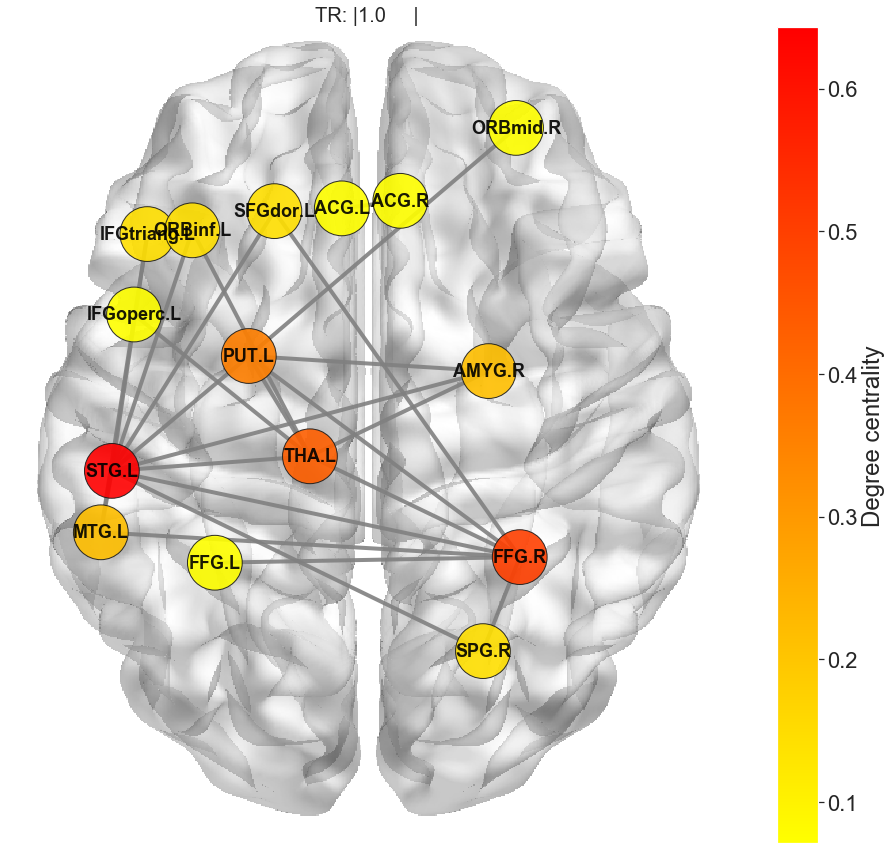

C:\Users\reza.bonyadi\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


TR:  2
1.6388888888888888


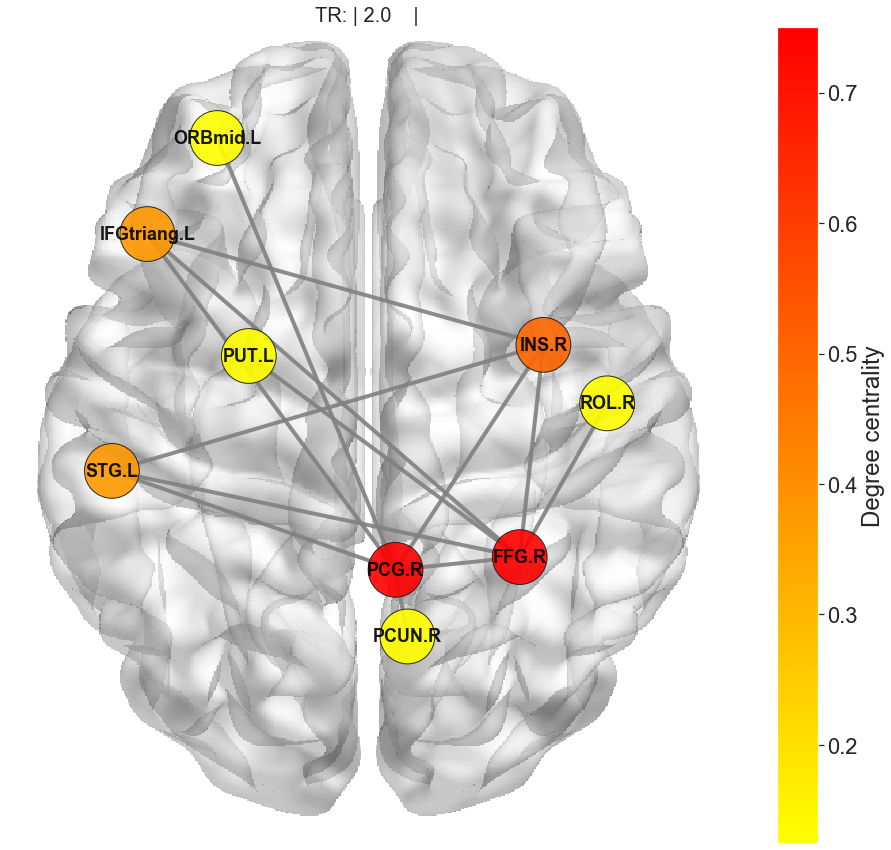

TR:  3
3.0545454545454547


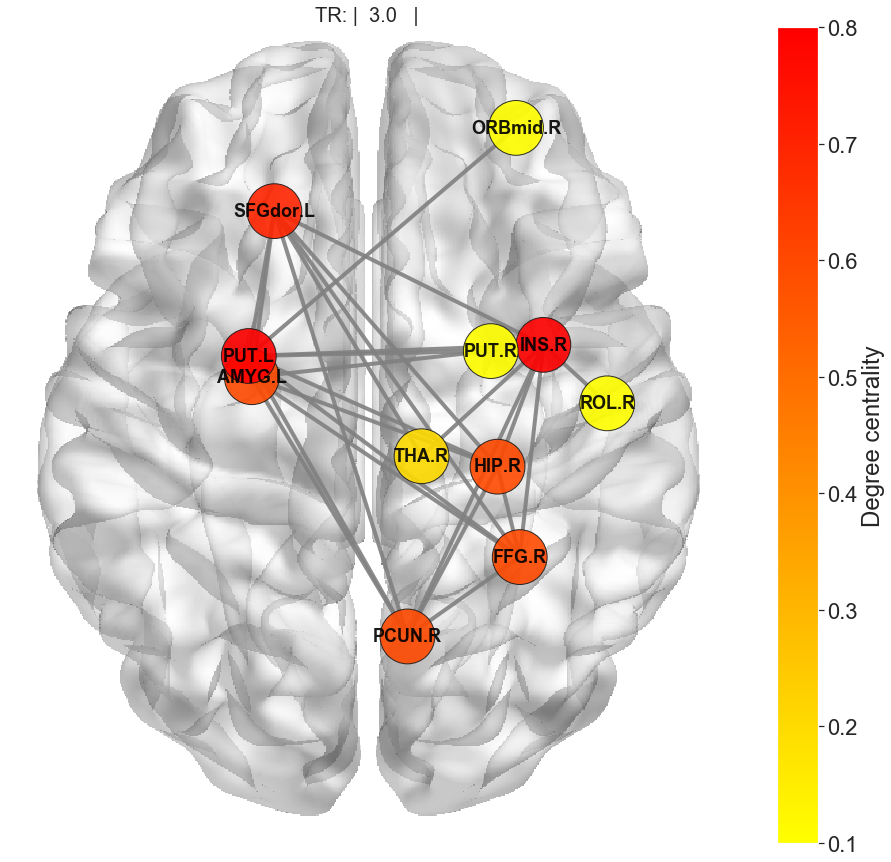

TR:  4
3.5555555555555554


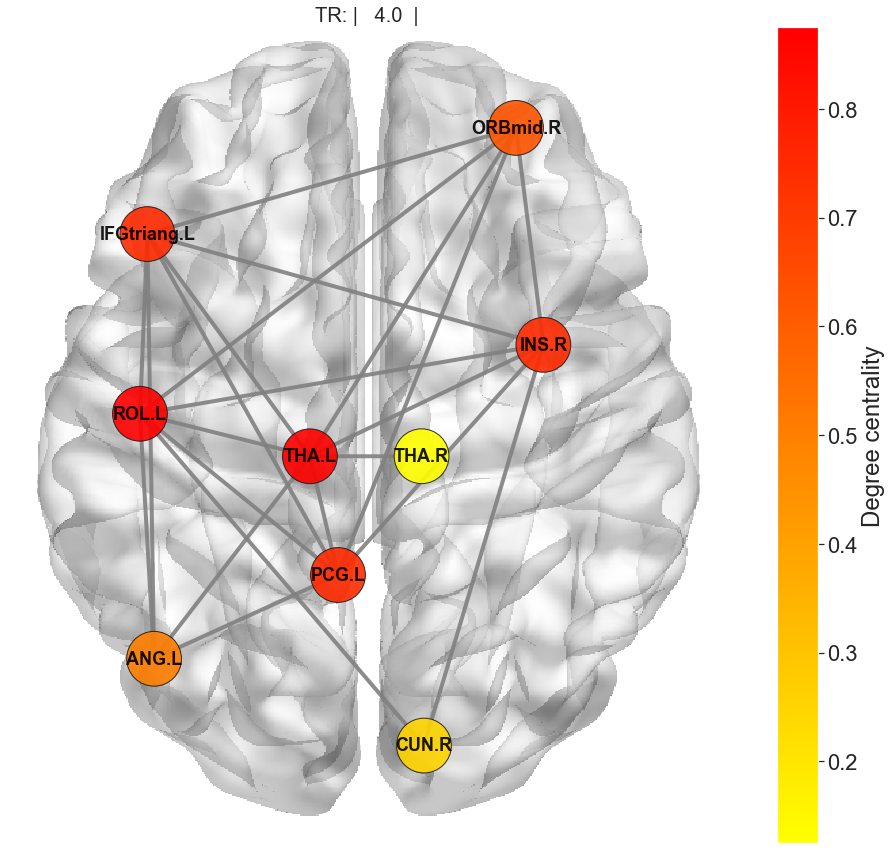

TR:  5
1.3956043956043955


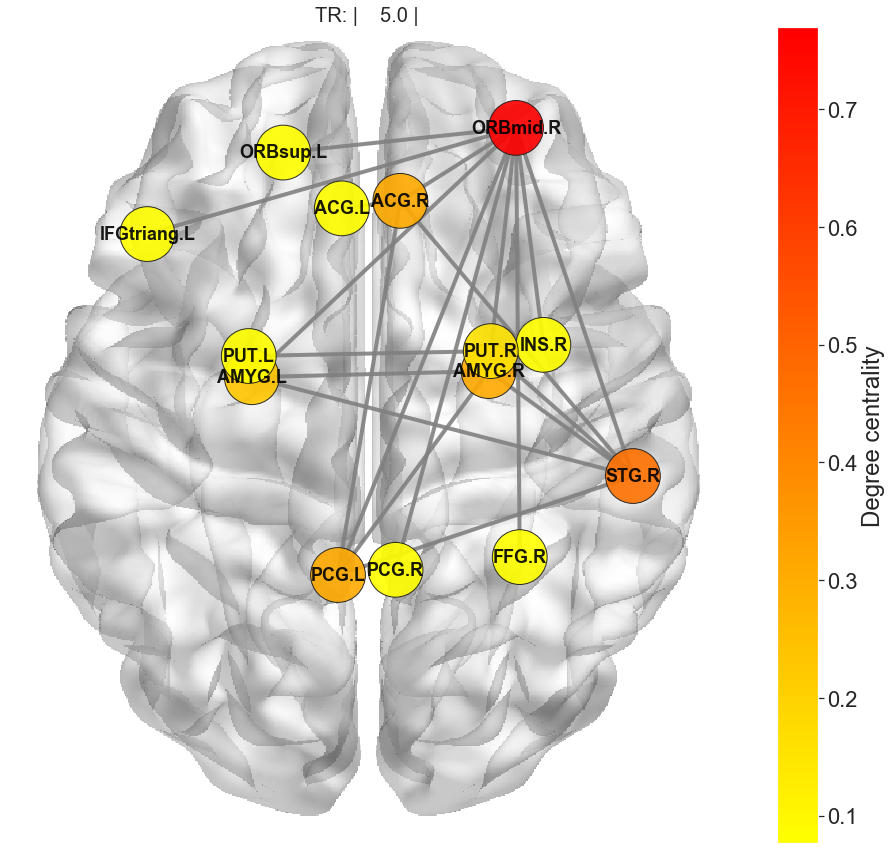

TR:  6
4.083333333333333


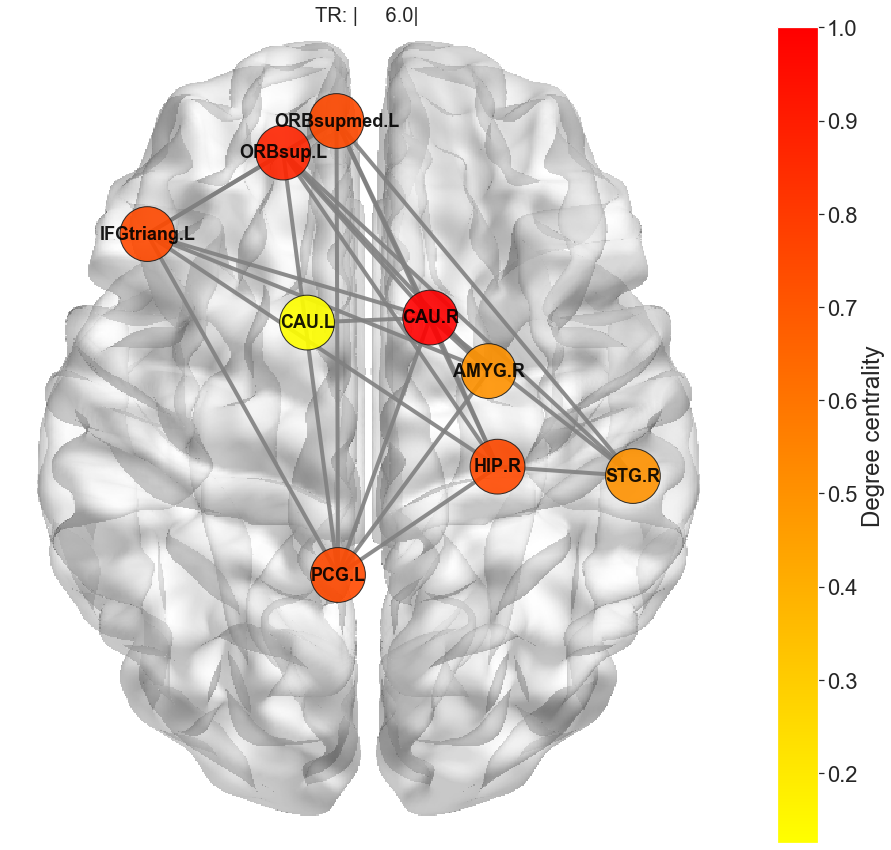

In [97]:
# Now visualize Markov Random Field
import imageio
vis_thr = .95
images = []
ma_slc = 7
mi_slc = 1
show_all_nodes = False
save_gif = False
gif_name = 'fcf_9.gif'
show_report = False

for slc in range(mi_slc, ma_slc):
    slc_indx = np.where(significant_trs==slc)[0][0]
    print('TR: ', slc)
    df = connectivity_df[slc_indx]
    G, _ = get_graph(df, vis_thr) 
    
    if show_all_nodes:
        for r in region_names:
            G.add_node(r)    
    
    if show_report:
        print('Communities: ')
        print('Modularity: ', community_louvain.modularity(part, G, weight='strength'))
    part = community_louvain.best_partition(G, weight='strength', resolution=.9)
        
    values = [part.get(node) for node in G.nodes()]
    for i in np.unique(values):
        indx = np.where(i==values)
        if show_report:
            print(np.asarray(G.nodes)[indx])
        
    if show_report:
        print('Degree centrality:')
        print(nx.algorithms.degree_centrality(G))
    
        print('Degree:')
        print(G.degree)
        
    print(nx.algorithms.average_node_connectivity(G))

    node_color = np.double(np.asarray(G.degree)[:,1])
    
    t = ((ma_slc-mi_slc)*[' '])
    t[slc-mi_slc] = str(np.floor(slc))
    title = ''.join(t)
    title = ''.join(['TR: |', title, '|'])
    
    color, bar_title = (np.array(list(nx.algorithms.degree_centrality(G).values()))), 'Degree centrality'
    size =3000
    layout = 'brain'    
    
    img = graph_show(G, node_color=color, node_size=size, title=title, layout=layout, color_bar_title=bar_title) # Use degree to color

    images.append(img)
    
if save_gif:
    imageio.mimsave(gif_name, images, fps=1)


In [98]:
vis_thr = .95
images = []
ma_slc = 7
mi_slc = 1
show_all_nodes = False
save_gif = False
gif_name = 'fcf_9.gif'
show_report = False
df_degress = []
for slc in range(mi_slc, ma_slc):
    slc_indx = np.where(significant_trs==slc)[0][0]
    print('TR: ', slc)
    df = connectivity_df[slc_indx]
    G, _ = get_graph(df, vis_thr) 
    
    color, bar_title = (np.array(list(nx.algorithms.degree_centrality(G).values()))), 'Degree centrality'
    degs = (pd.DataFrame(np.asarray([np.asarray(list(G.nodes)), color]).T, columns=['Region', 'Degree']))
    df_degress.append(degs)
    

TR:  1
TR:  2
TR:  3
TR:  4
TR:  5
TR:  6


TR:  1
['AMYG.R' 'STG.L' 'THA.L' 'MTG.L' 'IFGoperc.L' 'IFGtriang.L' 'ORBinf.L'
 'ORBsupmed.L']
['FFG.L' 'FFG.R' 'ORBmid.R' 'PUT.L' 'SPG.R']
Name: 
Type: Graph
Number of nodes: 13
Number of edges: 22
Average degree:   3.3846


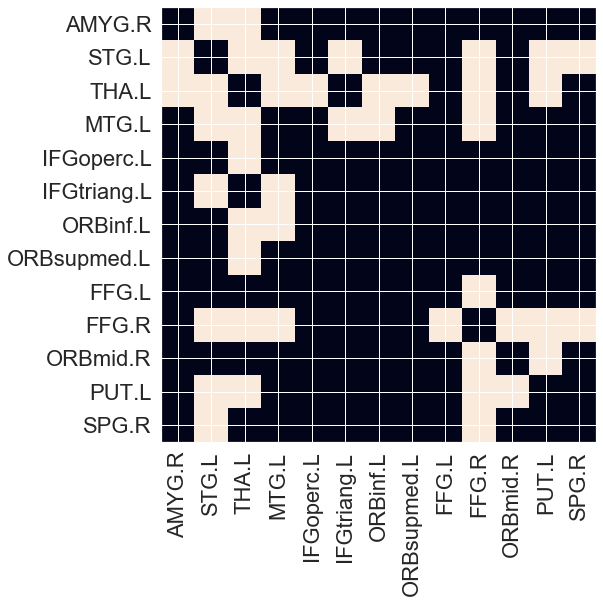

TR:  2
['FFG.R' 'IFGtriang.L' 'PCG.R' 'PUT.L' 'STG.L' 'INS.R' 'PCUN.R']
Name: 
Type: Graph
Number of nodes: 7
Number of edges: 9
Average degree:   2.5714


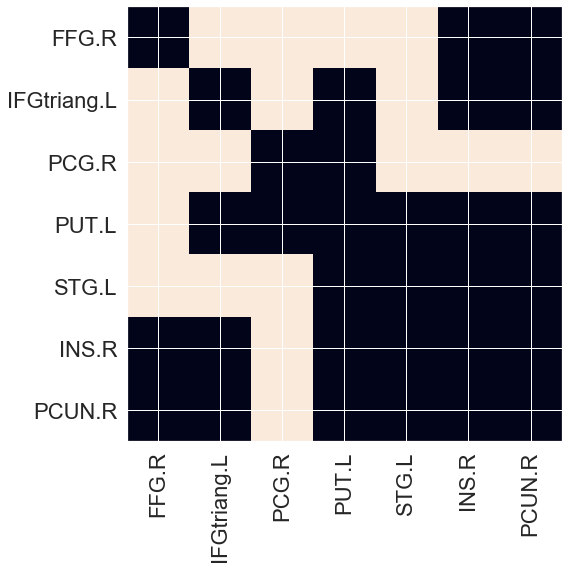

TR:  3
['AMYG.L' 'FFG.R' 'HIP.R' 'INS.R' 'PCUN.R' 'PUT.L' 'SFGdor.L' 'SFGmed.L'
 'ROL.R' 'THA.R' 'ORBmid.R' 'PUT.R']
Name: 
Type: Graph
Number of nodes: 12
Number of edges: 28
Average degree:   4.6667


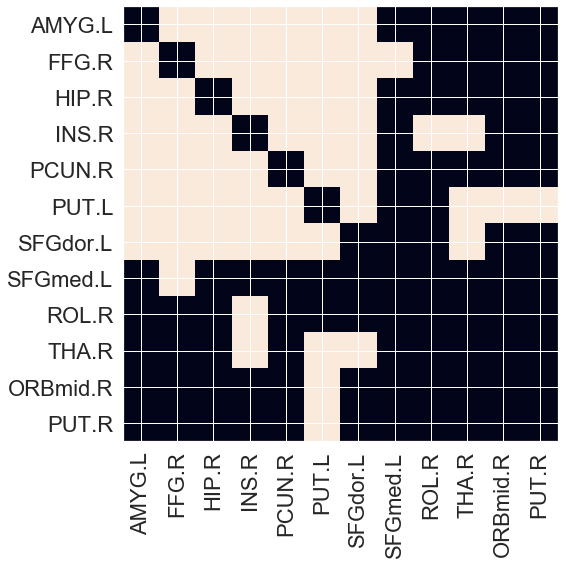

TR:  4
['ANG.L' 'IFGtriang.L' 'CUN.R' 'INS.R' 'ROL.L' 'FFG.L' 'ORBmid.R' 'PCG.L'
 'THA.L' 'ORBsupmed.L' 'STG.R' 'THA.R']
Name: 
Type: Graph
Number of nodes: 12
Number of edges: 22
Average degree:   3.6667


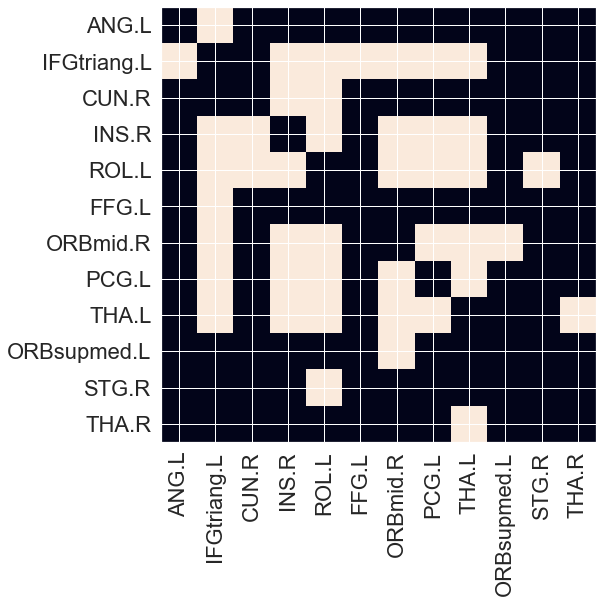

TR:  5
['ACG.L' 'ACG.R' 'AMYG.R' 'ORBmid.R' 'PCG.L' 'PCG.R' 'STG.R' 'AMYG.L'
 'FFG.R' 'IFGtriang.L' 'INS.R' 'PUT.R']
Name: 
Type: Graph
Number of nodes: 12
Number of edges: 20
Average degree:   3.3333


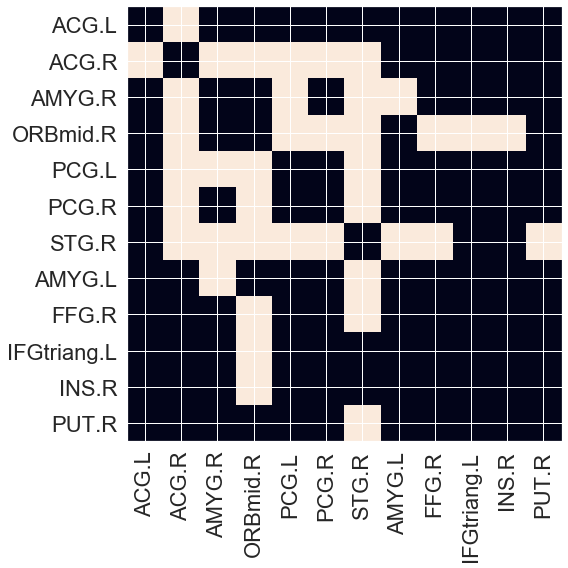

TR:  6
['AMYG.R' 'CAU.R' 'IFGtriang.L' 'ORBsup.L' 'HIP.R' 'ORBsupmed.L' 'PCG.L'
 'STG.R']
Name: 
Type: Graph
Number of nodes: 8
Number of edges: 24
Average degree:   6.0000


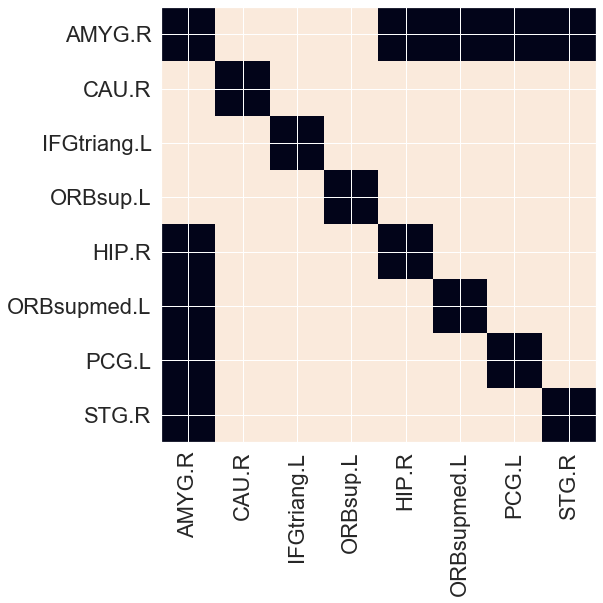

TR:  9
['AMYG.L' 'PCG.R' 'IFGoperc.L' 'IFGtriang.R' 'SFGdor.L' 'STG.L' 'THA.R']
['SFGmed.R' 'SFGmed.L']
['ROL.R' 'STG.R']
Name: 
Type: Graph
Number of nodes: 11
Number of edges: 16
Average degree:   2.9091


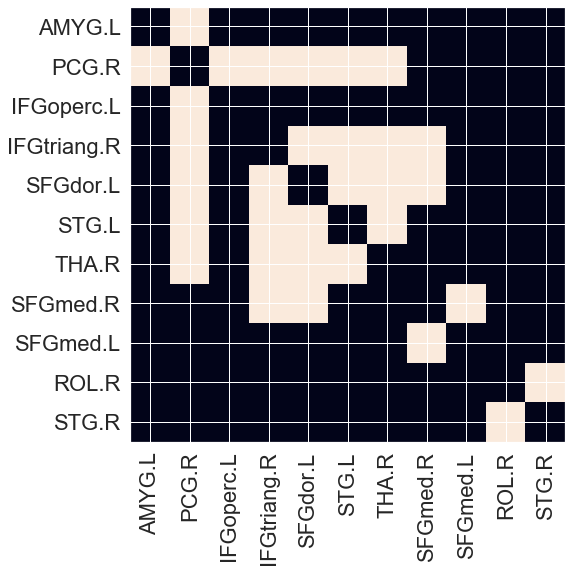

TR:  10
['AMYG.L' 'ORBmid.L' 'THA.R' 'ORBsupmed.R' 'THA.L']
['PUT.L' 'PUT.R']
Name: 
Type: Graph
Number of nodes: 7
Number of edges: 8
Average degree:   2.2857


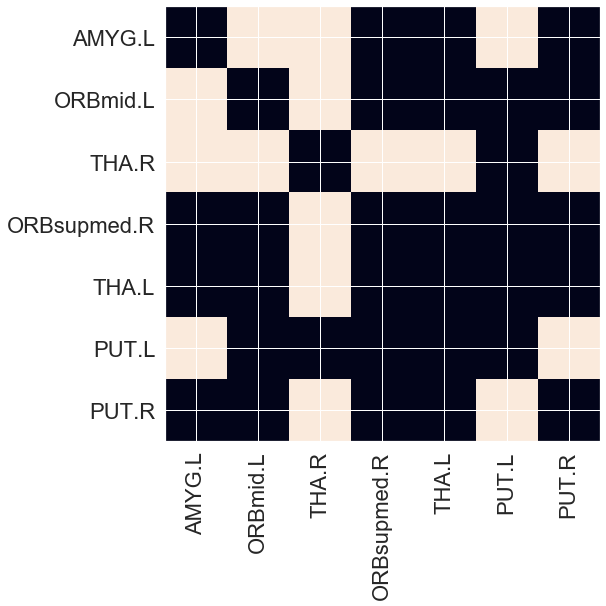

TR:  11
['AMYG.L' 'HIP.L' 'IFGoperc.R' 'MTG.R' 'ORBinf.L' 'SFGmed.L' 'THA.L']
Name: 
Type: Graph
Number of nodes: 7
Number of edges: 12
Average degree:   3.4286


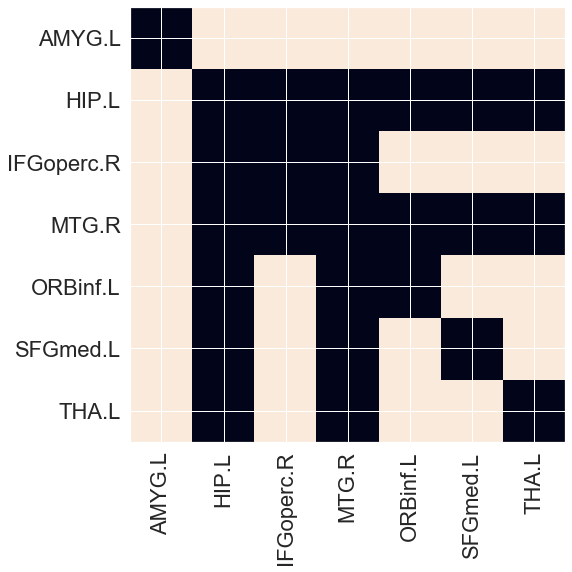

TR:  17
['ACG.L' 'ACG.R' 'AMYG.R' 'FFG.R' 'IPL.R' 'PUT.L' 'SPG.L']
['ORBinf.L' 'PUT.R' 'ROL.L' 'SFGmed.R' 'PCG.R' 'SFGmed.L']
Name: 
Type: Graph
Number of nodes: 13
Number of edges: 18
Average degree:   2.7692


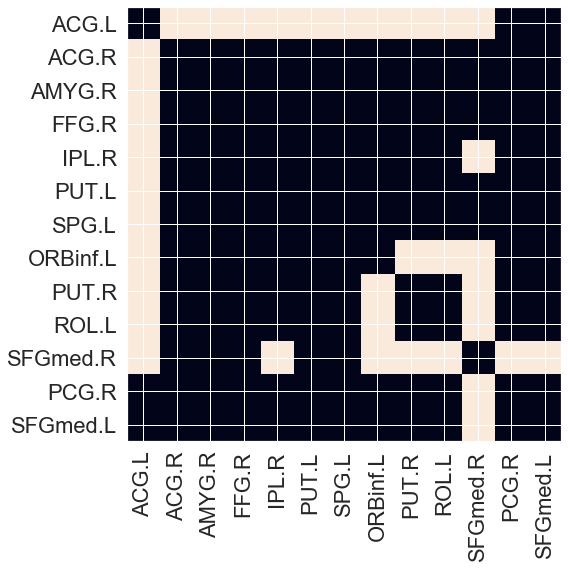

In [79]:
# Graph heatmaps
# import community

vis_thr = importance_threshold
vis_thr = .95
for slc_indx in range(significant_trs.shape[0]):
    slc = significant_trs[slc_indx]
    print('TR: ', slc)
    df = connectivity_df[slc_indx]
    G, _ = get_graph(df, vis_thr) 
    
    part = community_louvain.best_partition(G, resolution=1.5)
    values = [part.get(node) for node in G.nodes()]
    G1 = nx.Graph()

    for i in np.unique(values):
        indx = np.where(i==values)
        print(np.asarray(G.nodes)[indx])
        G1.add_nodes_from(np.asarray(G.nodes)[indx])
        
    G1.add_edges_from(G.edges)

    print((nx.info(G1)))
    to_show = nx.adj_matrix(G1, weight='strength').todense()
    
    plt.imshow(to_show.T)
    nodes = np.asarray(G1.nodes)
    plt.xticks(np.arange(to_show.shape[1]), nodes, rotation=90)
    plt.yticks(np.arange(to_show.shape[1]), nodes)
#     plt.colorbar()

    plt.show()
#     print(arr)

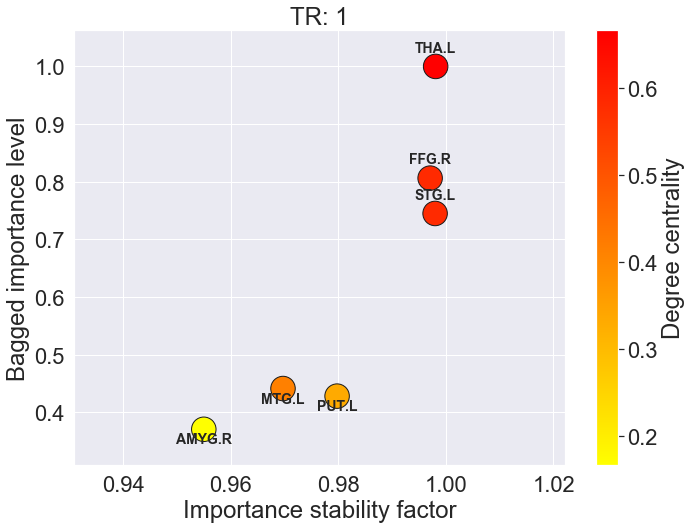

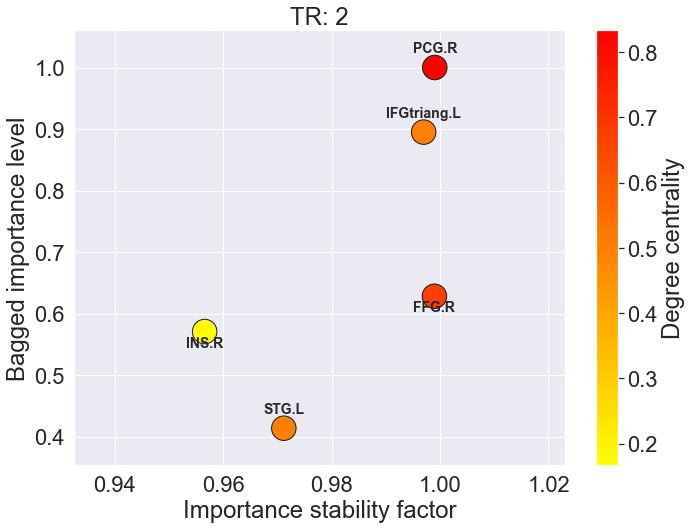

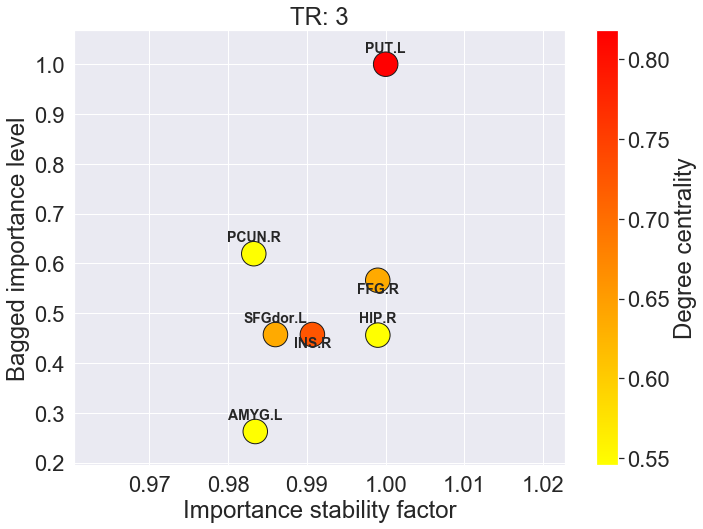

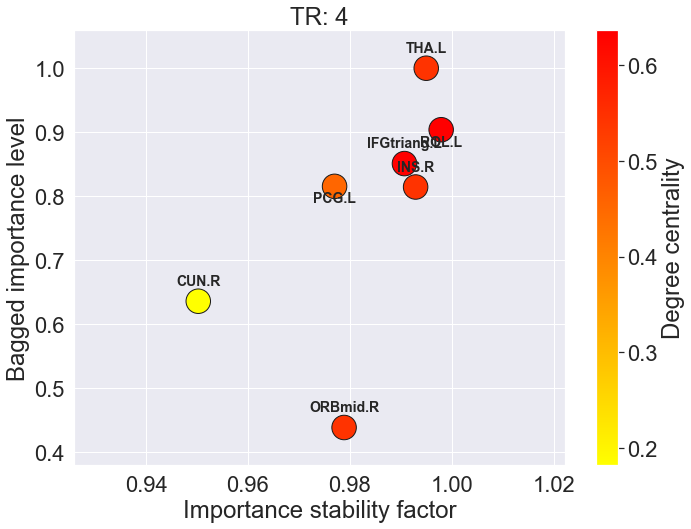

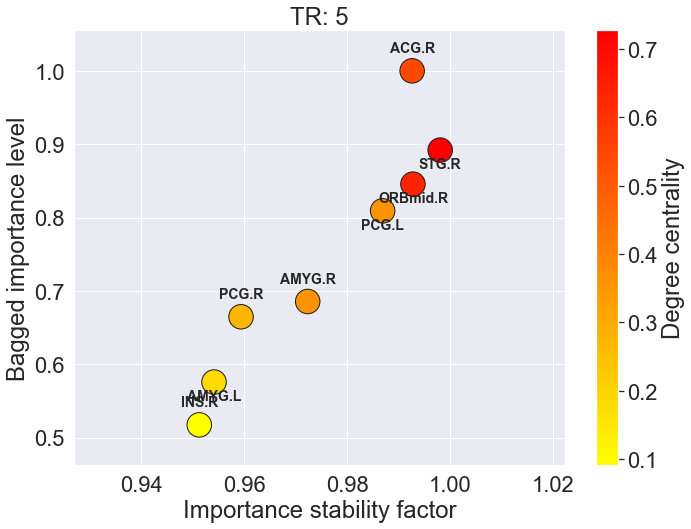

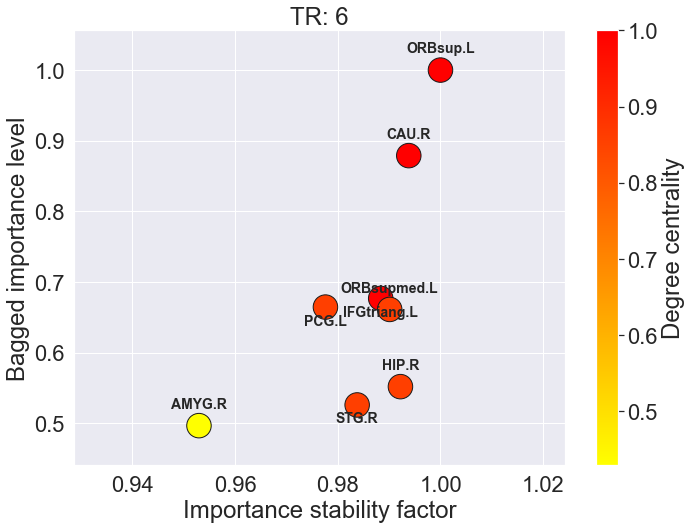

In [80]:
thr = .95
for slc_indx in range(significant_trs.shape[0]):
    slc = significant_trs[slc_indx]
    if slc>7:
        continue
    df = connectivity_df[slc_indx]
    G, _ = get_graph(df, vis_thr) 
    dict_size=nx.algorithms.degree_centrality(G)
#     dict_size = dict(G.degree)
    
    x = regions_importance_portion[:,slc]
    y = regions_importance_value_bootstrap_mean[:,slc]
    y=y/max(y)
    s = []
    for i in range(x.shape[0]):
        if x[i]>thr:
            r = np.double(2*np.random.randint(2)-1)
            plt.text(x[i], y[i]+r*0.025, region_names[i], fontsize=14, weight='bold', ha='center')  
            deg = dict_size.get(region_names[i])
            if deg is None:
                deg = 1
            s.append(deg)
        
    plt.scatter((x[x>thr]), y[x>thr], c=s, edgecolors='k', cmap=plt.cm.autumn_r, s=600)
    plt.xlabel('Importance stability factor')
    plt.ylabel('Bagged importance level')
    plt.title(''.join(['TR: ', str(slc)]))
    hndl = plt.colorbar()
    hndl.set_label('Degree centrality')
    
    plt.show()


# brainnet outputs

In [272]:
# Importance portion
f_name = 'to_vis/regions/test_1'
vis_threshold = importance_threshold
for slc in significant_trs:
    if slc>=10:
        continue
    c=regions_importance_portion[:,slc]
    cords = np.squeeze(reg_cords[np.where(c>vis_threshold),:])
    strengths = c[c>vis_threshold]
    
    f=open(''.join([f_name, str(slc), '.node']), 'w')
    for i in range(cords.shape[0]):
        to_write = [cords[i,1], cords[i,2], cords[i,3], slc, strengths[i], cords[i,0]]
        f.write('%s %s %s %d %f %s\n' %(cords[i,1], cords[i,2], cords[i,3], slc, strengths[i], cords[i,0]))
    f.close()
    
    print(slc, ',', reg_cords[np.where(c>vis_threshold),:])
    

1 , [[['FFG.R' '33.97' '-39.1' '-20.18']
  ['LING.R' '16.29' '-66.93' '-3.87']
  ['ORBinf.L' '-35.98' '30.71' '-12.11']
  ['STG.L' '-53.16' '-20.68' '7.13']
  ['THA.L' '-10.85' '-17.56' '7.98']]]
2 , [[['FFG.R' '33.97' '-39.1' '-20.18']
  ['IFGtriang.L' '-45.58' '29.91' '13.99']
  ['INS.R' '39.02' '6.25' '2.08']
  ['PCG.R' '7.44' '-41.81' '21.87']
  ['STG.L' '-53.16' '-20.68' '7.13']
  ['TPOsup.L' '-39.88' '15.14' '-20.18']]]
3 , [[['AMYG.L' '-23.27' '-0.67' '-17.14']
  ['FFG.R' '33.97' '-39.1' '-20.18']
  ['HIP.R' '29.23' '-19.78' '-10.33']
  ['INS.R' '39.02' '6.25' '2.08']
  ['PUT.L' '-23.91' '3.86' '2.4']
  ['SFGdor.L' '-18.45' '34.81' '42.2']
  ['TPOmid.R' '44.22' '14.55' '-32.23']]]
4 , [[['ANG.L' '-44.14' '-60.82' '35.59']
  ['IFGtriang.L' '-45.58' '29.91' '13.99']
  ['INS.R' '39.02' '6.25' '2.08']
  ['IOG.R' '38.16' '-81.99' '-7.61']
  ['ORBmid.R' '33.18' '52.59' '-10.73']
  ['PCG.L' '-4.85' '-42.92' '24.67']
  ['PHG.R' '25.38' '-15.15' '-20.47']
  ['ROL.L' '-47.16' '-8.48' '13.

In [273]:
# Importance connections
f_name = 'to_vis/connections/test_1'
vis_threshold = importance_threshold
for slc_indx in range(significant_trs.shape[0]):
    slc = significant_trs[slc_indx]
    if slc>=10:
        continue
    
    G, _ = get_graph(connectivity_df[slc_indx], vis_threshold)
    regs = list(G.nodes)
    
    f=open(''.join([f_name, str(slc), '.node']), 'w')
    
    for reg in regs:
        region_indx = np.where(region_names==reg)[0][0]
        cords = reg_cords[region_indx, :]        
        f.write('%s %s %s %d %f %s\n' %(cords[1], cords[2], cords[3], slc, 1, cords[0]))
    f.close()
    
    arr = nx.adj_matrix(G, weight='strength').todense()
    np.savetxt(''.join([f_name, str(slc), '.edge']), arr)
    
    print(slc)
    
# f=open(''.join([f_name, str(slc), '.edge']), 'w')


1
2
3
4
5
6
